In [2]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

# Data retrieval
sc.settings.set_figure_params(dpi=50, facecolor="white")

# Load your liver FACS Smart-seq2 data
adata = sc.read_h5ad("tabula-muris-senis-droplet-processed-official-annotations-Liver.h5ad")  # path to your file

# Make sure variable (gene) names are unique
adata.var_names_make_unique()

# Make sure observation (cell) names are unique
adata.obs_names_make_unique()

# Inspect AnnData object
print(adata)

#display the pandas crosstab 
print(pd.crosstab(adata.obs['age'], adata.obs['mouse.id']))

c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(
c:\Users\lukas\miniconda3\envs\sc_env\Lib\site-packages\anndata\_io\h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(


AnnData object with n_obs × n_vars = 7294 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
mouse.id  1-M-62  1-M-63  3-F-56  3-F-57  3-M-8/9  18-F-51  21-F-54  24-M-58  \
age                                                                            
1m           471    2320       0       0        0        0        0        0   
3m             0       0     387     179      460        0        0        0   
18m            0       0       0       0        0      698        0        0   
21m            0       0       0       0        0        0      367       

As we can see, starting the workflow on the processed droplet data to compare with the facs data, we have a difference in the number of mice, introducing more biological variables. In the facs data we have 9 mice and here we have 12, with more time points collected, like 1, 21 and 30 months.

Also its important to note, as previously mentioned, 10x genomics provides breath with 7294 cells to analyse but only 20138 genes associated, while Smart-Seq 2 provides depth with much less cells (around 3000) but a higher number of genes (around 22000). 

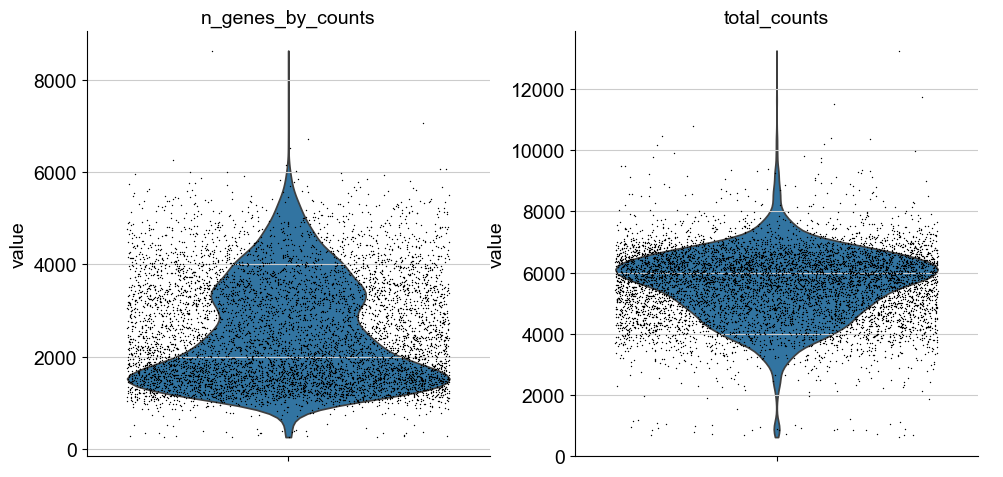

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

# Calculate basic QC metrics (without gene sets)
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Violin plots for key QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts'],
    jitter=0.4,
    multi_panel=True,
)

These are good cell distributions with minor to negligent sub populations representing technical errors, like doublets or oversequencing. On the left we have the Count of unique genes per cell and on the right we have the total count of genes per cell. We can see on the right graph a subpopulations at very low counts, possibly representing artifacts, but his is to be expected since the sample is much larger.

Created new categories in 'age_sex':
['18m_female', '21m_female', '24m_male', '30m_male', '1m_male', '3m_male', '3m_female']




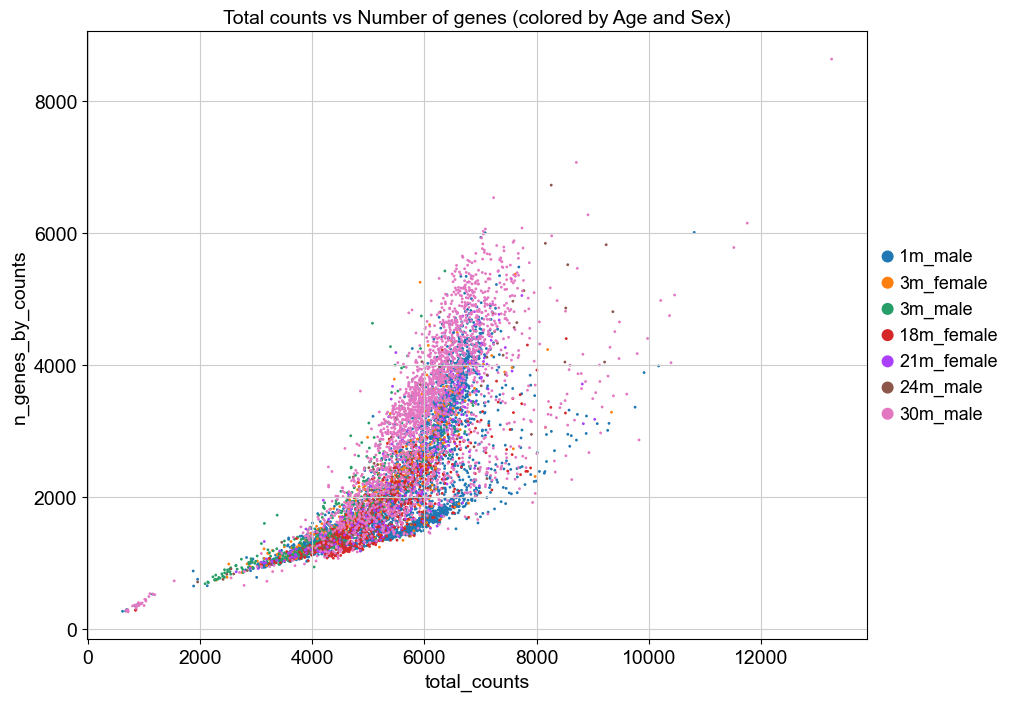

In [3]:
# --- Create a new metadata column by combining 'age' and 'sex' ---
# Ensure 'age' is a string to combine it with 'sex'
adata.obs['age_sex'] = adata.obs['age'].astype(str) + '_' + adata.obs['sex'].astype(str)

print("Created new categories in 'age_sex':")
print(adata.obs['age_sex'].unique().tolist())
print("\n") # Add a newline for readability

# --- Create a matplotlib figure and axes with a specific size ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Plot using the new combined column for color ---
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="age_sex",  # Use the new combined column
    title="Total counts vs Number of genes (colored by Age and Sex)",
    ax=ax,
    show=False # Set show=False to prevent duplicate plotting
)
plt.show()

We can see here that again the cell distribution looks good, with the outlier population close to zero. We see also, coloring by age_sex that the 30 month male has a large distribution by itself, which could influence the data.

In [4]:
# Run Scrublet doublet detection, per sample/batch
sc.pp.scrublet(adata)  # or "sample" if you prefer

# Quick look at the added columns
print(adata.obs[['doublet_score', 'predicted_doublet']].head())

# Check the total number of cells before filtering
original_counts = adata.n_obs
print("Original counts before removing doublets:")
print(original_counts)

# Check number of predicted doublets
doublet_counts = adata.obs['predicted_doublet'].sum()
print("\nNumber of predicted doublets:")
print(doublet_counts)

# Remove predicted doublets
#adata = adata[~adata.obs['predicted_doublet'], :].copy()

# Save filtered data
#adata.write("Liver_facs_filtered.h5ad")

                          doublet_score  predicted_doublet
index                                                     
AAACCTGAGATGTCGG-1-9-0-0       0.033036              False
AAAGCAATCGGAAATA-1-9-0-0       0.006474              False
AAAGTAGAGGCCCTTG-1-9-0-0       0.014042              False
AACCGCGAGAAACCGC-1-9-0-0       0.020480              False
AACTCCCAGTTGTCGT-1-9-0-0       0.007756              False
Original counts before removing doublets:
7294

Number of predicted doublets:
4


Implementing the same logic as for the facs workflow, where only 1 cell was predicted as a doublet. Here we have 4 predicted cells. Given that the number of cells here increase also almost fourfold, i will choose not to remove these cells, since they are around the same ratio as doublets in the facs dataset.

In [5]:
# Save the raw counts in a separate layer
adata.layers["counts"] = adata.X.copy()

# Normalize each cell by total counts to median count depth
sc.pp.normalize_total(adata)  # default: target_sum = median count depth

# Log1p transform (log(x + 1))
sc.pp.log1p(adata)

# Quick check
print(adata)

# After normalization and log1p
adata.write("Liver_droplet_normalized.h5ad")

AnnData object with n_obs × n_vars = 7294 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'age_sex', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'age_sex_colors', 'scrublet', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


Data has now been normalized and transformed just like before.

highly_variable
False    18138
True      2000
Name: count, dtype: int64


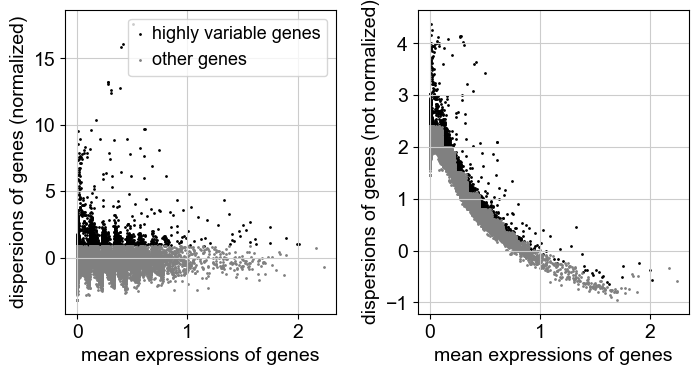

In [6]:
# Load the filtered, normalized data
adata = sc.read_h5ad("Liver_droplet_normalized.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Highly variable gene selection
# n_top_genes = 2000 as in the tutorial
# batch_key = "batch" to account for multiple batches
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Quick check of HVG annotation
print(adata.var.highly_variable.value_counts())

# Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

# Save the HVG-annotated data for the next step
adata.write("Liver_droplet_normalized_HVG.h5ad")

Again, a good distribution of HGVs after normalization although we can see a definitive increase in dispersion levels in comparison with the facs data which we can correlate with the increase in cell sample size.

c:\Users\lukas\miniconda3\envs\sc_env\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


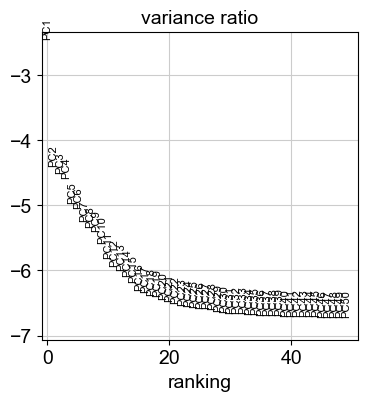

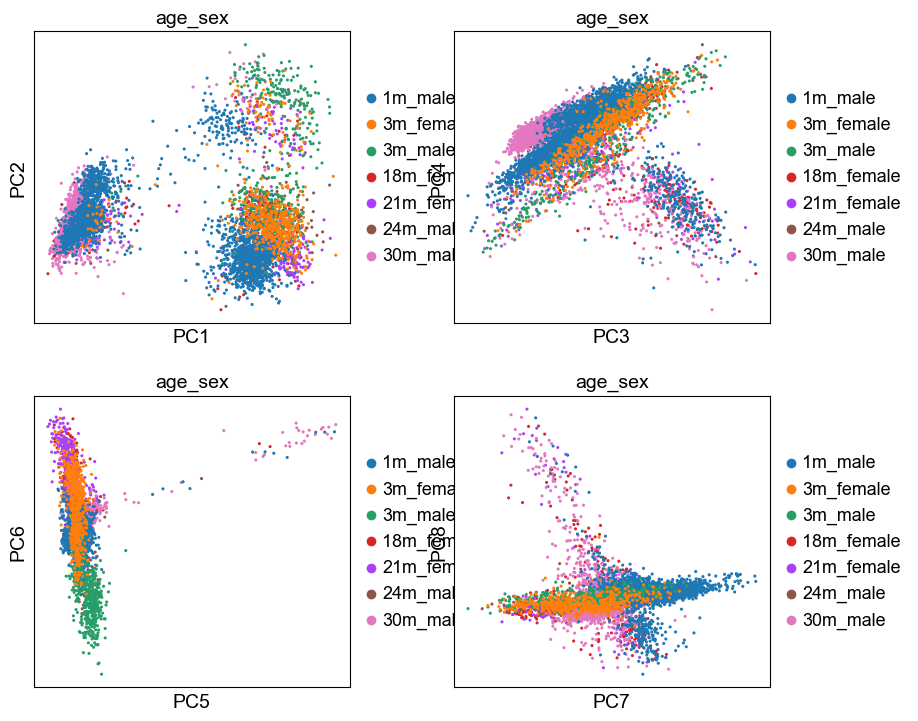

PCA done. Dataset shape: (7294, 20138)


In [7]:
# Load the HVG-only dataset from feature selection step
adata = sc.read_h5ad("Liver_droplet_normalized_HVG.h5ad")
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Scale the data (zero mean, unit variance)
sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

# Inspect variance explained by PCs
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, show=True)

# PCA scatter plots colored by batch
sc.pl.pca(
    adata,
    color=["age_sex"],  # "sample" is another option
    dimensions=[(0, 1), (2, 3), (4, 5), (6, 7)],
    ncols=2,
    size=20
)

# Save the PCA-processed dataset
adata.write("Liver_droplet_normalized_HVG_reduced.h5ad")

print("PCA done. Dataset shape:", adata.shape)

Given the increase in biological variables and cell sample size it makes sense that the segregation between batches is more severe here in droplet data than in facs data. It can be visualized mainly in the first plot where it seems like two groups from the 7 dominate the leftmost cluster, and again in the third plot we can see a definite separation between clusters pink, blue and gree with cluster orange more more distributed through these clusters.

Also it seems like the principal components that capture the msot variance don't really explain the 24 month male or the 18 month female. These are possibly explained by later PCs as perhaps they aren't a large part of the variance of the data.

As for the Scree plot we can see an elbow at around PC16, but to be consistent with the facs data I will choose to include up until PC20, as there isn't an appreciable difference that we should be worried will introduce technical artifcats.

Loading data with pre-computed PCA from Liver_droplet_normalized_HVG_reduced.h5ad...
Building neighborhood graph...
Running Leiden clustering for multiple resolutions...

Clustering results for multiple resolutions have been stored:
                         leiden_0.5 leiden_0.75 leiden_1.0
index                                                     
AAACCTGAGATGTCGG-1-9-0-0          0           0          0
AAAGCAATCGGAAATA-1-9-0-0          0           0          0
AAAGTAGAGGCCCTTG-1-9-0-0          0           0          0
AACCGCGAGAAACCGC-1-9-0-0          0           0          0
AACTCCCAGTTGTCGT-1-9-0-0          0           0          0
Computing and plotting UMAP...


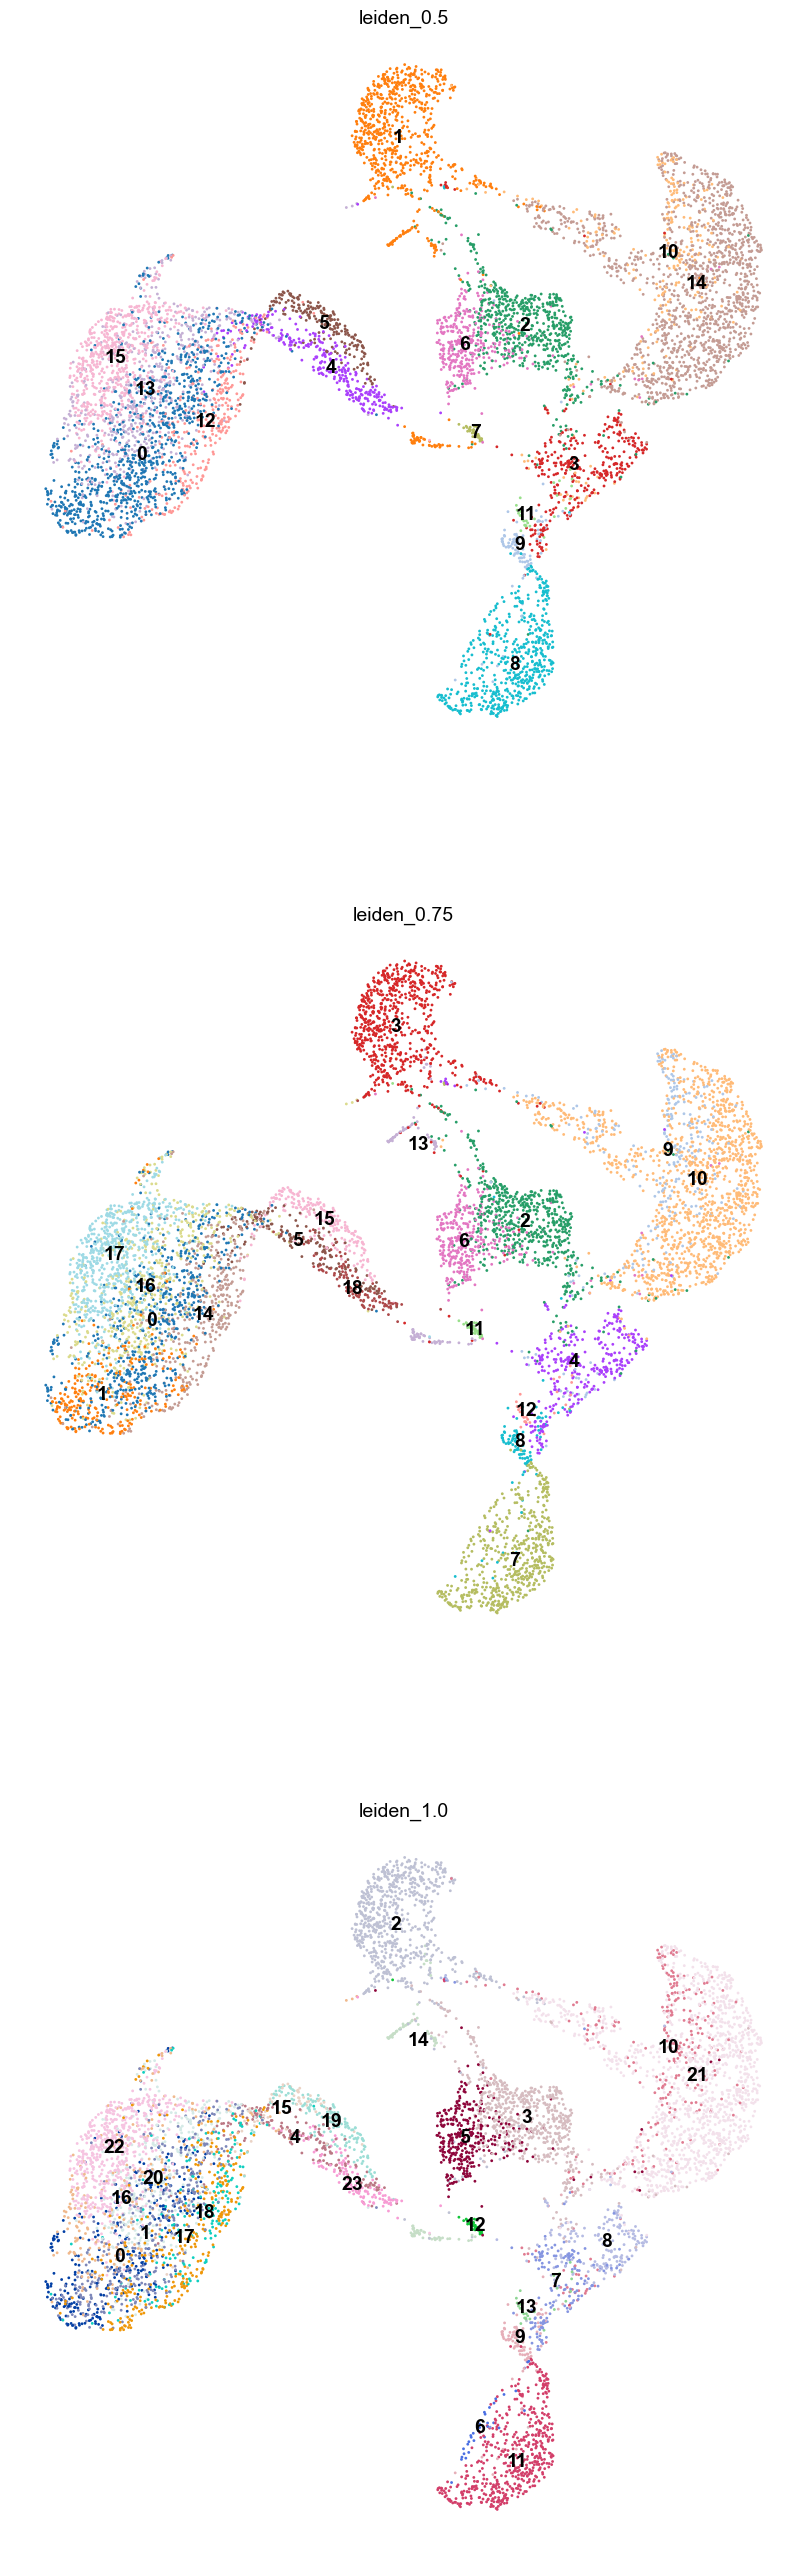

Saving clustered data to Liver_droplet_normalized_HVG_reduced_clustered.h5ad...

 Clustering script finished successfully.


In [8]:
# Define the input file (your data with PCA already computed)
# and the name for the output file.
input_file = "Liver_droplet_normalized_HVG_reduced.h5ad"
output_file = "Liver_droplet_normalized_HVG_reduced_clustered.h5ad"

# --- 2. LOAD THE PRE-COMPUTED PCA DATA ---
print(f"Loading data with pre-computed PCA from {input_file}...")
adata = sc.read_h5ad(input_file)

# --- 3. BUILD NEIGHBORHOOD GRAPH ---
# This step uses the PCA results already stored in adata.obsm['X_pca'].
# We are creating the neighborhood graph based on the data.
print("Building neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

# --- 4. LEIDEN CLUSTERING ON DATA ---
print("Running Leiden clustering for multiple resolutions...")

# --- Resolution 0.5 ---
sc.tl.leiden(
    adata,
    resolution=0.5,
    key_added='leiden_0.5',  # Store result in 'leiden_0.5'
    flavor="igraph",
    n_iterations=2
)

# --- Resolution 0.75 ---
sc.tl.leiden(
    adata,
    resolution=0.75,
    key_added='leiden_0.75', # Store result in 'leiden_0.75'
    flavor="igraph",
    n_iterations=2
)

# --- Resolution 1.0 ---
sc.tl.leiden(
    adata,
    resolution=1.0,
    key_added='leiden_1.0',  # Store result in 'leiden_1.0'
    flavor="igraph",
    n_iterations=2
)

# --- Verification ---
# You can now see all three results stored as separate columns in adata.obs
print("\nClustering results for multiple resolutions have been stored:")
print(adata.obs[['leiden_0.5', 'leiden_0.75', 'leiden_1.0']].head())

# --- 5. VISUALIZATION ---
# Compute the UMAP based on the graph.
print("Computing and plotting UMAP...")

with plt.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(
        adata,
        color=['leiden_0.5', 'leiden_0.75', 'leiden_1.0'], # Your results
        legend_loc='on data',
        frameon=False,
        ncols=1 # Arrange plots in a single column
    )
# --- 6. SAVE THE CLUSTERED DATA ---
print(f"Saving clustered data to {output_file}...")
adata.write(output_file)

print("\n Clustering script finished successfully.")

These clusters overall have a visual closer to the original clustering by the researchers, implying that the largest drivers of the structure of the data, even without batch correction, is the droplet data.

Here I have visualized as before the three different leiden cluster resolutions. Since there is more data and variables the clustering will also be deeper than in the facs data, where the resolution of 1.0 was chosen. Here that resolution looks like a possibility given that we can make a substanciated guess that the leftmost cluster represents the immune cell types, so a deeper clustering is better. But there seems to be over clustering in the "bridge" population between the leftmost cluster and the center cluster, with 4 clusters predicted. This could in fact be the case, but it seems more the case of the same cell type being characterized by different mice. 

Either way this resolution looks like it captures more biological signals than the lower resolutions, so we will choose this one, keeping the comparison with the facs data relevant.

After doing the dotplot, which is saved, at this resolution I saw many different clusters which did not have relevant signals for the marker genes. This made me come back and reevaluate my decision for the 1.0 resolution where I gave more weight to the "immune" cluster than the clusters where it did seem like they did not need to exist. So I will also do the dotplot for the marker gene set at 0.75 resolution, which will also be saved. Diminishing the comparison relevancy between facs and droplet data.

Generating dotplot for clusters in 'leiden_0.75'...


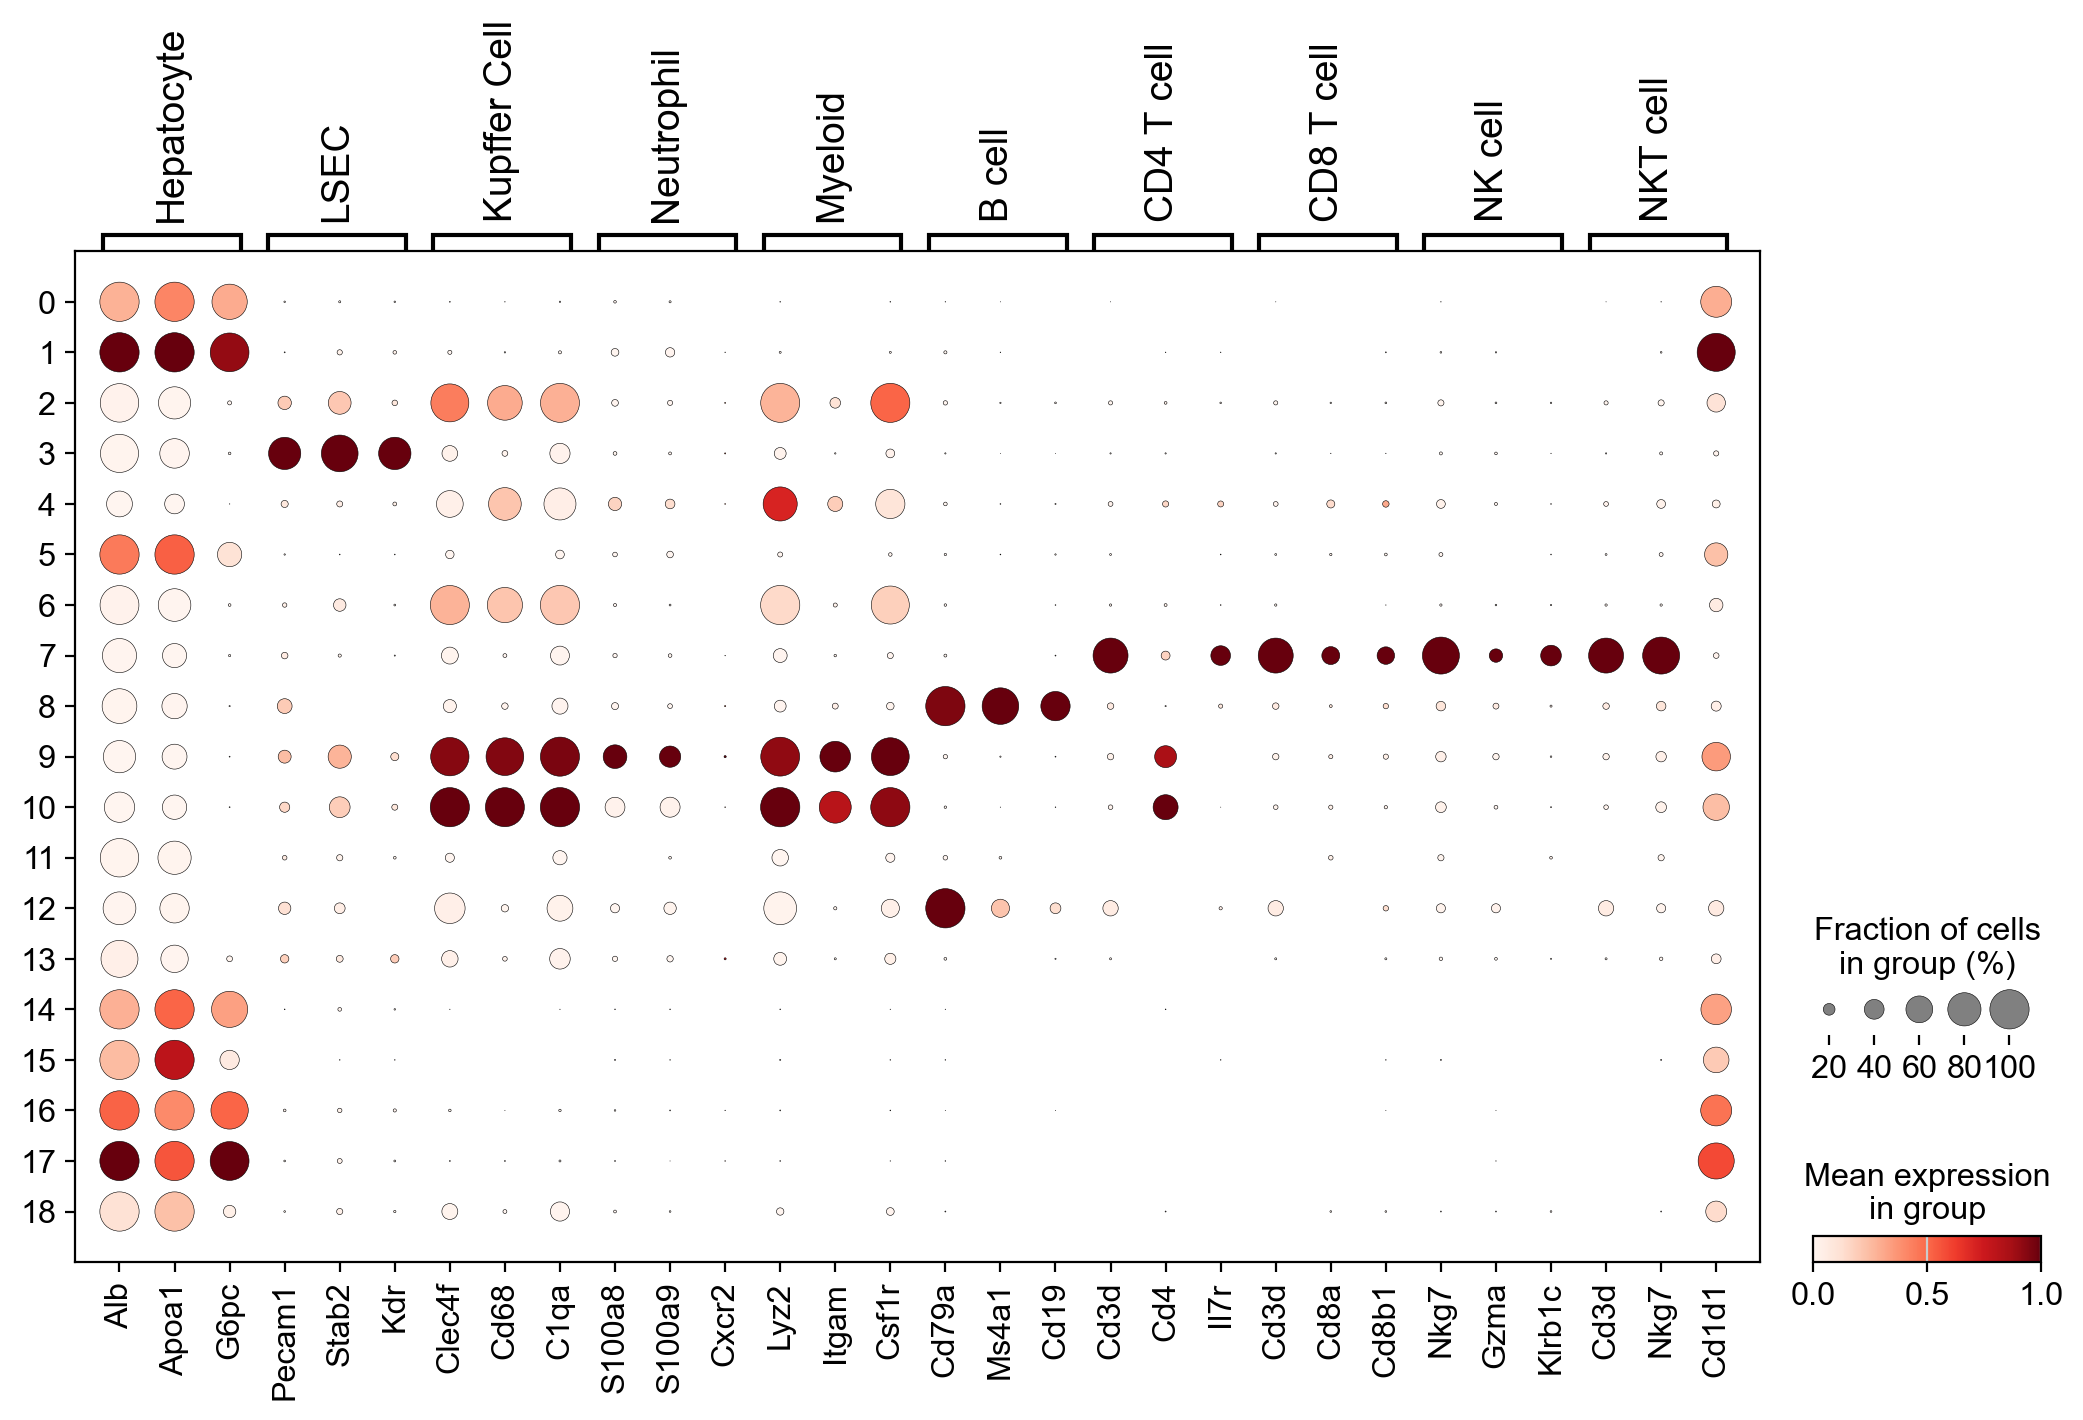


Finished mapping cluster numbers to cell type names.
Value counts for the new 'cell_type' annotation:
cell_type
Hepatocyte/NKT_mix                    2417
Kupffer/Myeloid/CD4_mix               1305
Kupffer/Myeloid_mix                   1301
LSEC                                   670
Immune_mix                             544
Hepatocyte                             512
Kupffer/Myeloid/Neutrophil/CD4_mix     281
Unknown                                137
B cell                                 127
Name: count, dtype: int64

Visualizing final annotation on UMAP...


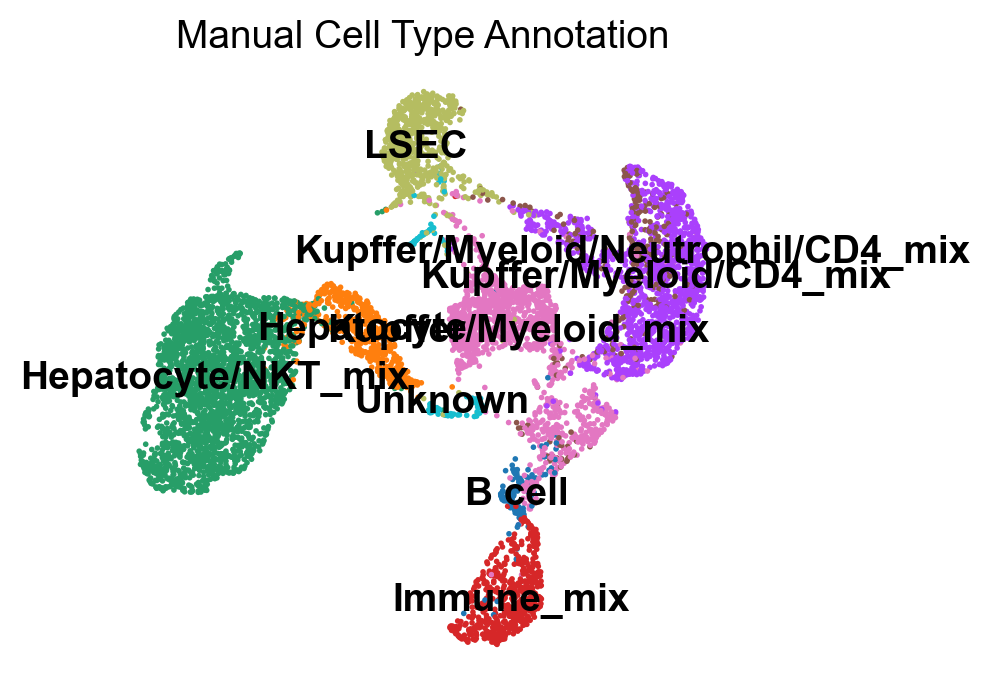


Visualizing final dotplot with cell type labels...


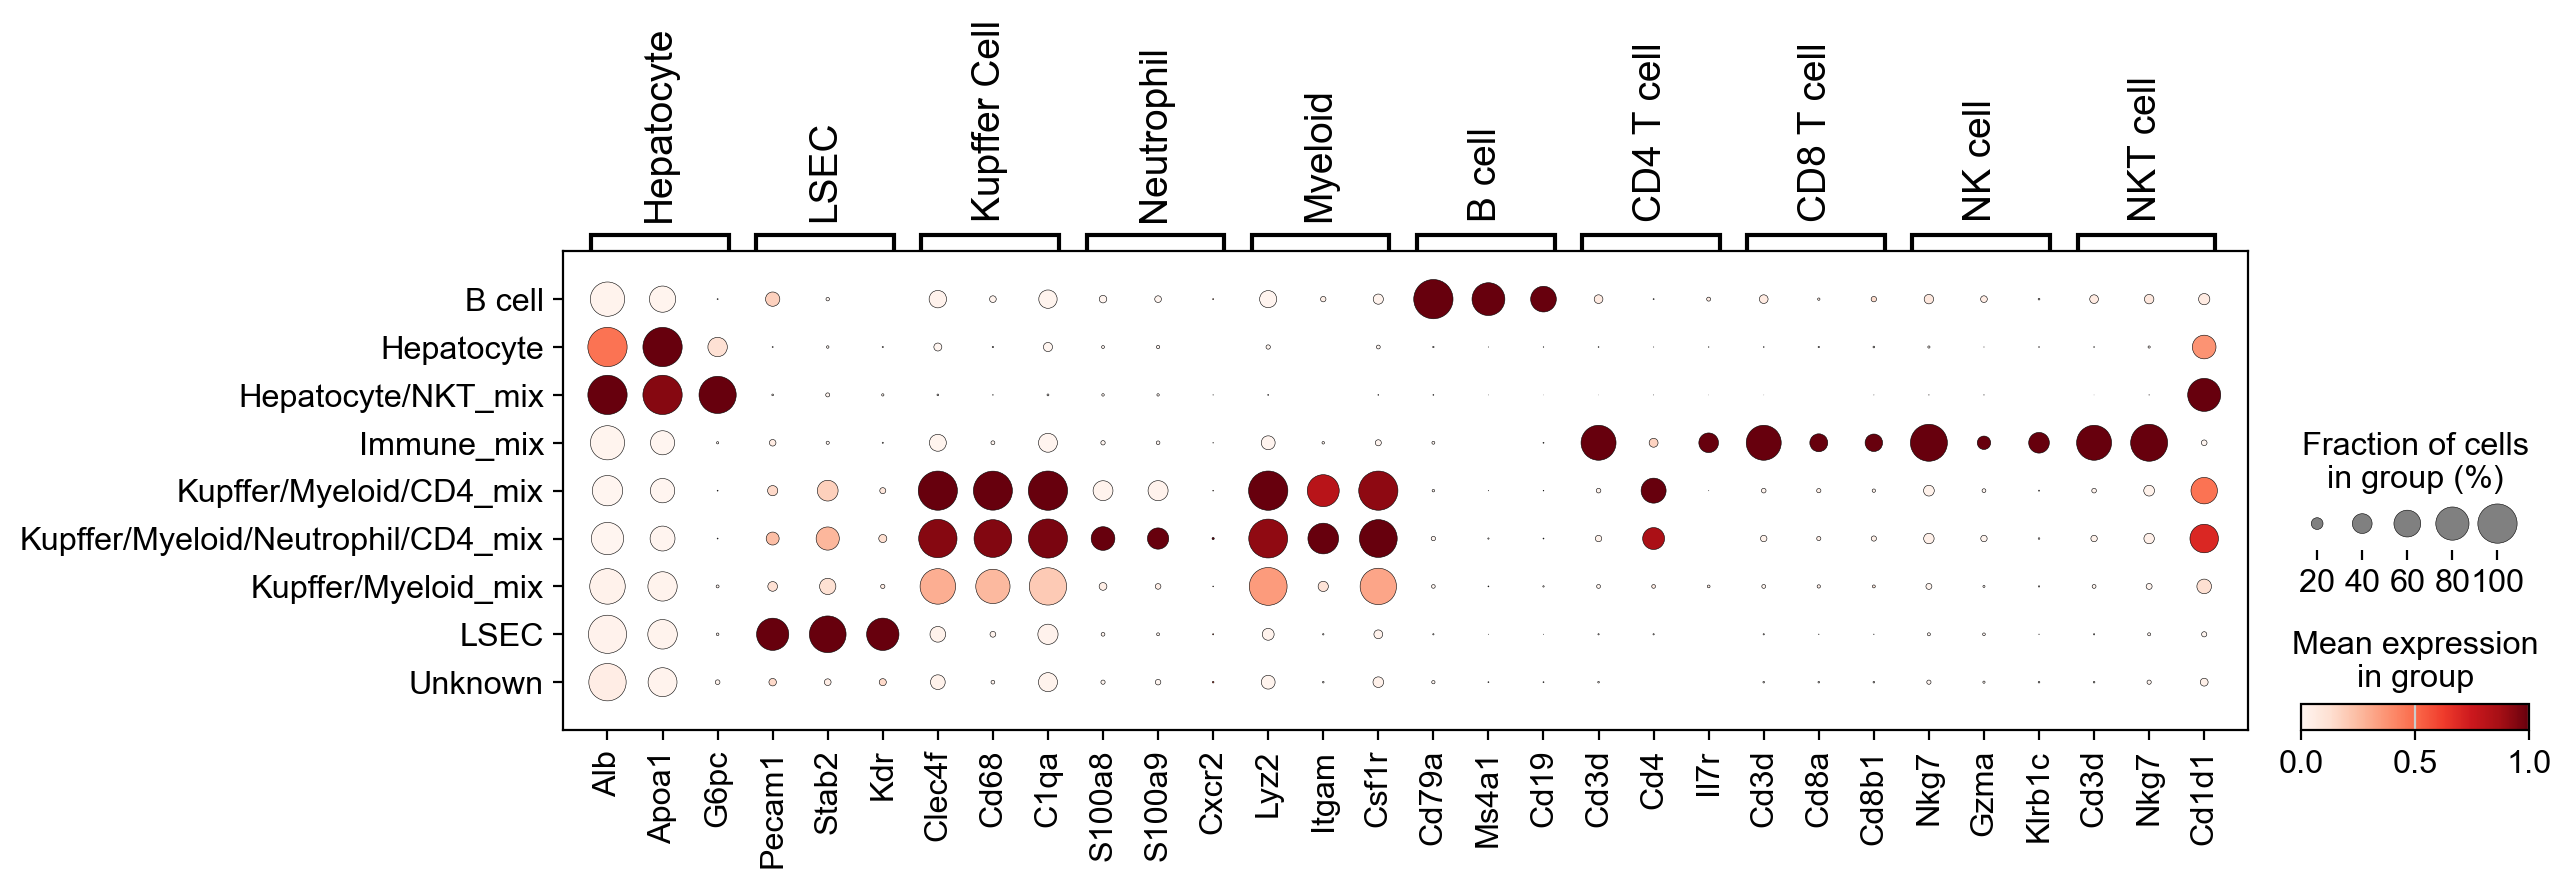

In [4]:
# --- Manual Annotation using Marker Genes for Liver Data ---
# Setup Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # Increased DPI for clarity

# 1. Load the AnnData object with clustering results
# Make sure this is the correct file containing your Leiden clustering column
adata = sc.read_h5ad('Liver_droplet_normalized_HVG_reduced_clustered.h5ad')


# 2. Define the new, more detailed set of marker genes for LIVER cell types
# These markers are based on the cell types you provided.
new_liver_marker_genes = {
    'Hepatocyte': ['Alb', 'Apoa1', 'G6pc'],
    'LSEC': ['Pecam1', 'Stab2', 'Kdr'], # Liver Sinusoidal Endothelial Cells
    'Kupffer Cell': ['Clec4f', 'Cd68', 'C1qa'], # Liver-resident macrophages
    'Neutrophil': ['S100a8', 'S100a9', 'Cxcr2'],
    'Myeloid': ['Lyz2', 'Itgam', "Csf1r"], # General myeloid marker (includes many types)
    'B cell': ['Cd79a', 'Ms4a1',"Cd19"], # Ms4a1 is CD20
    'CD4 T cell': ['Cd3d', 'Cd4', 'Il7r'],
    'CD8 T cell': ['Cd3d', 'Cd8a', 'Cd8b1'],
    'NK cell': ['Nkg7', 'Gzma', 'Klrb1c'], # Natural Killer cells (CD3 negative)
    'NKT cell': ['Cd3d', 'Nkg7',"Cd1d1"], # NK T cells (express both CD3 and NK markers)
}


# 3. Choose a resolution and visualize marker expression with a dotplot
# Make sure this key matches a column in your adata.obs
cluster_key_to_annotate = "leiden_0.75" # Example: using resolution 0.75

print(f"Generating dotplot for clusters in '{cluster_key_to_annotate}'...")
sc.pl.dotplot(adata, new_liver_marker_genes, groupby=cluster_key_to_annotate, standard_scale="var", show=True)

# 4. Manually map cluster numbers to cell type names based on the NEW dotplot

annotation_map = {
    '0': 'Hepatocyte/NKT_mix',
    '1': 'Hepatocyte/NKT_mix',
    '2': 'Kupffer/Myeloid_mix',
    '3': 'LSEC',
    '4': 'Kupffer/Myeloid_mix', 
    '5': 'Hepatocyte',
    '6': 'Kupffer/Myeloid_mix',
    '7': 'Immune_mix',
    '8': 'B cell',
    '9': 'Kupffer/Myeloid/Neutrophil/CD4_mix',
    '10': 'Kupffer/Myeloid/CD4_mix',
    '11': 'Unknown',
    '12': 'B cell',
    '13': 'Unknown',
    '14': 'Hepatocyte/NKT_mix',
    '15': 'Hepatocyte',
    '16': 'Hepatocyte/NKT_mix',
    '17': 'Hepatocyte/NKT_mix',
    '18': 'Hepatocyte', 
}

# Apply the mapping to create a new annotation column in adata.obs
if annotation_map: # Only run if the map is not empty
    adata.obs['cell_type'] = adata.obs[cluster_key_to_annotate].map(annotation_map).astype('category')

print("\nFinished mapping cluster numbers to cell type names.")
print("Value counts for the new 'cell_type' annotation:")
print(adata.obs['cell_type'].value_counts())

     # 5. Visualize the final annotation on the UMAP
print("\nVisualizing final annotation on UMAP...")
sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='Manual Cell Type Annotation', show=True)

     # 6. Visualize the annotated dotplot for confirmation
print("\nVisualizing final dotplot with cell type labels...")
sc.pl.dotplot(adata, new_liver_marker_genes, groupby='cell_type', standard_scale='var', show=True)

     # Optional: Save the final annotated object
adata.write_h5ad('Liver_droplet_normalized_HVG_reduced_clustered_annotated.h5ad')

There is more mixing in these clusters than in the facs data clusters. This is likely given the explanations mentioned before. Even at this resolution there were two clusters that could not be identified by the marker gene set annotation analysis. 

Also it seems like the leftmost cluster was not the immune cell type but overclustering.


Plotting UMAPs with coloring by age_sex


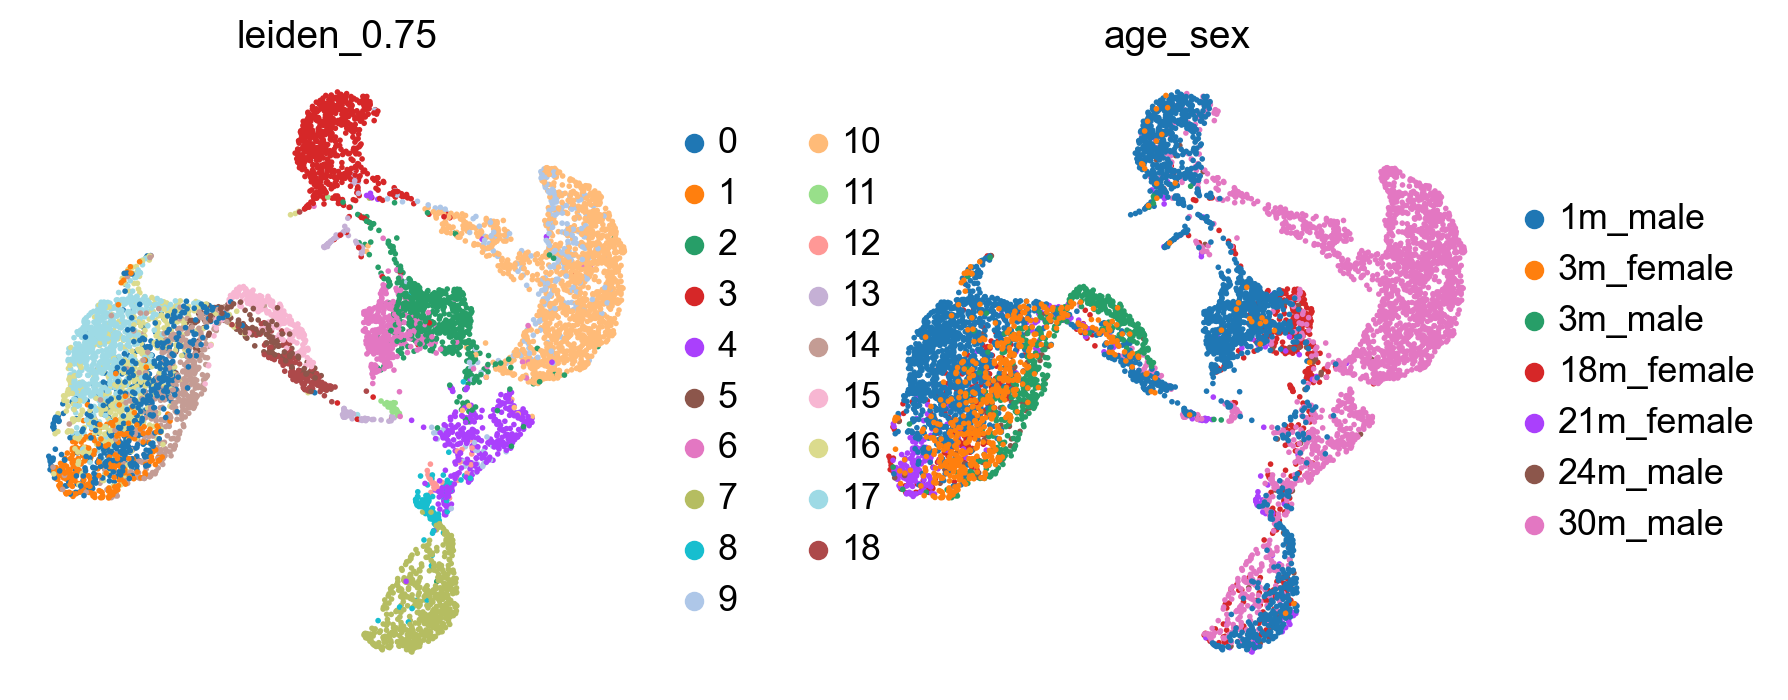

In [5]:
print("\nPlotting UMAPs with coloring by age_sex")
sc.pl.umap(
    adata,
    color=['leiden_0.75','age_sex'], # Pass the list of your results here
    legend_loc='right margin', # Puts the cluster number directly on the plot
    frameon=False,
    ncols=3, # Arrange the plots in a row with 3 columns
)

Once again my point of more segregation emerges. And the fact that, specifically, the 24 month male wasn't represented much in the PCA graphs and here again was due to it being only a small proportion of the overall cells, and that's why not a lot of variance is captured by those cells.

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Displaying top marker genes for each annotated cell type:


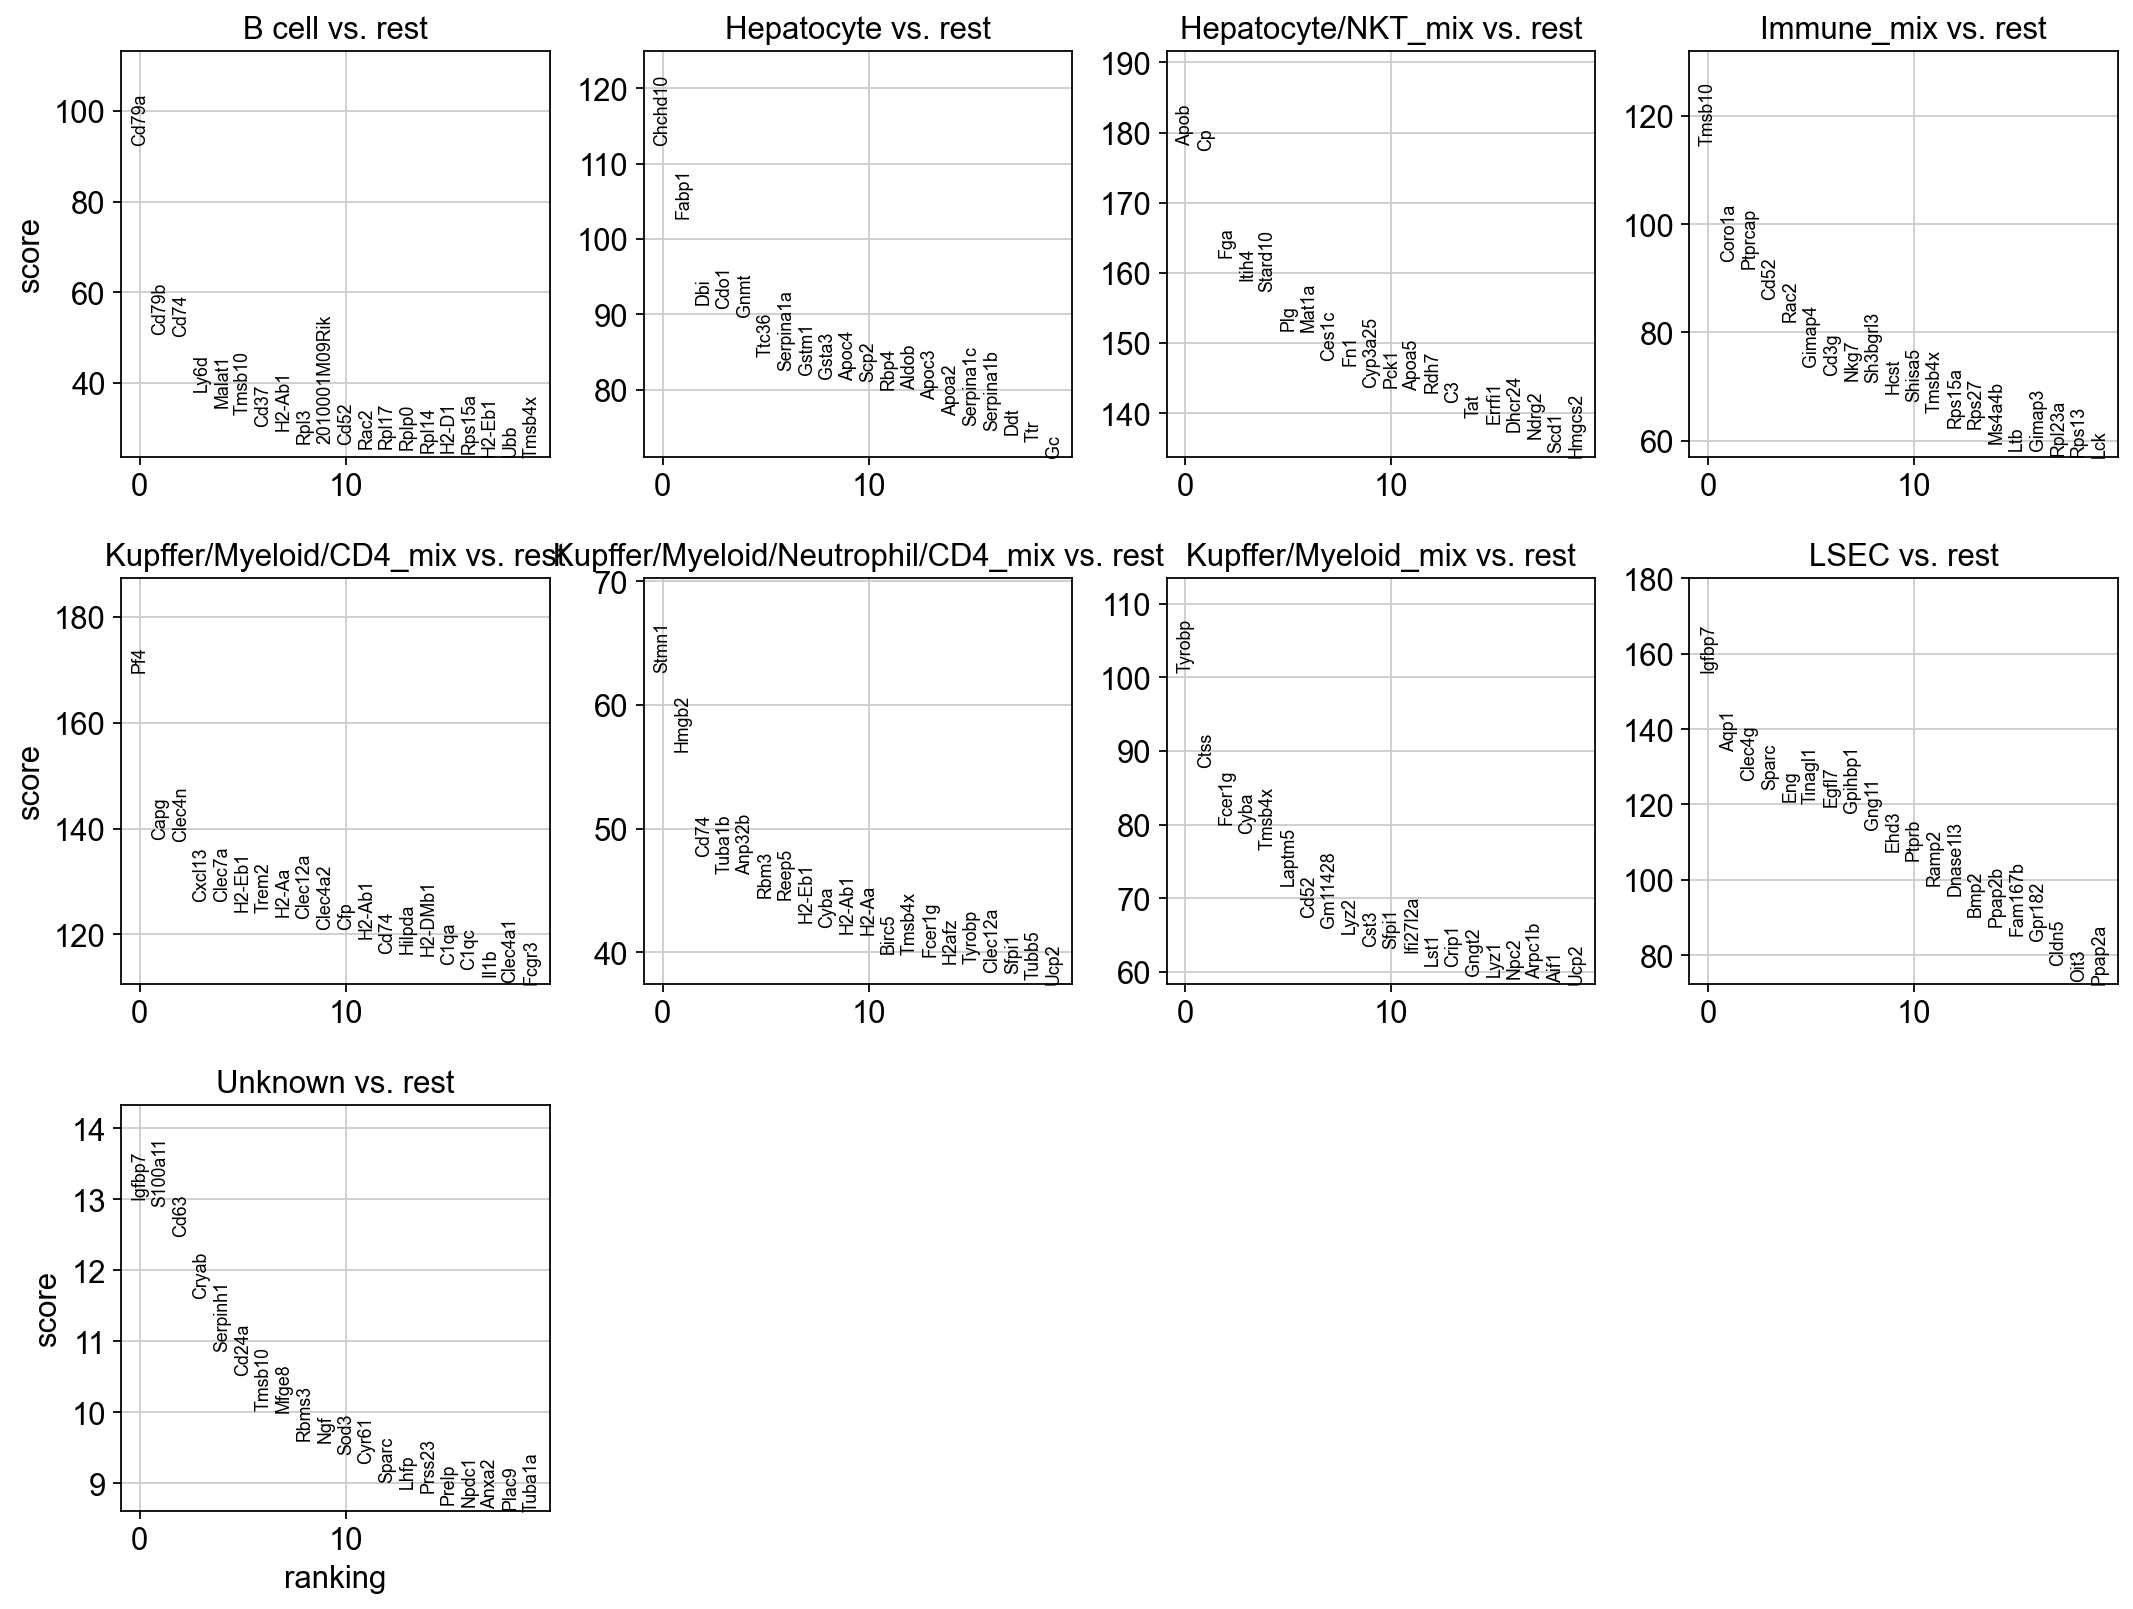


Displaying heatmap of top 10 markers per cell type:
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


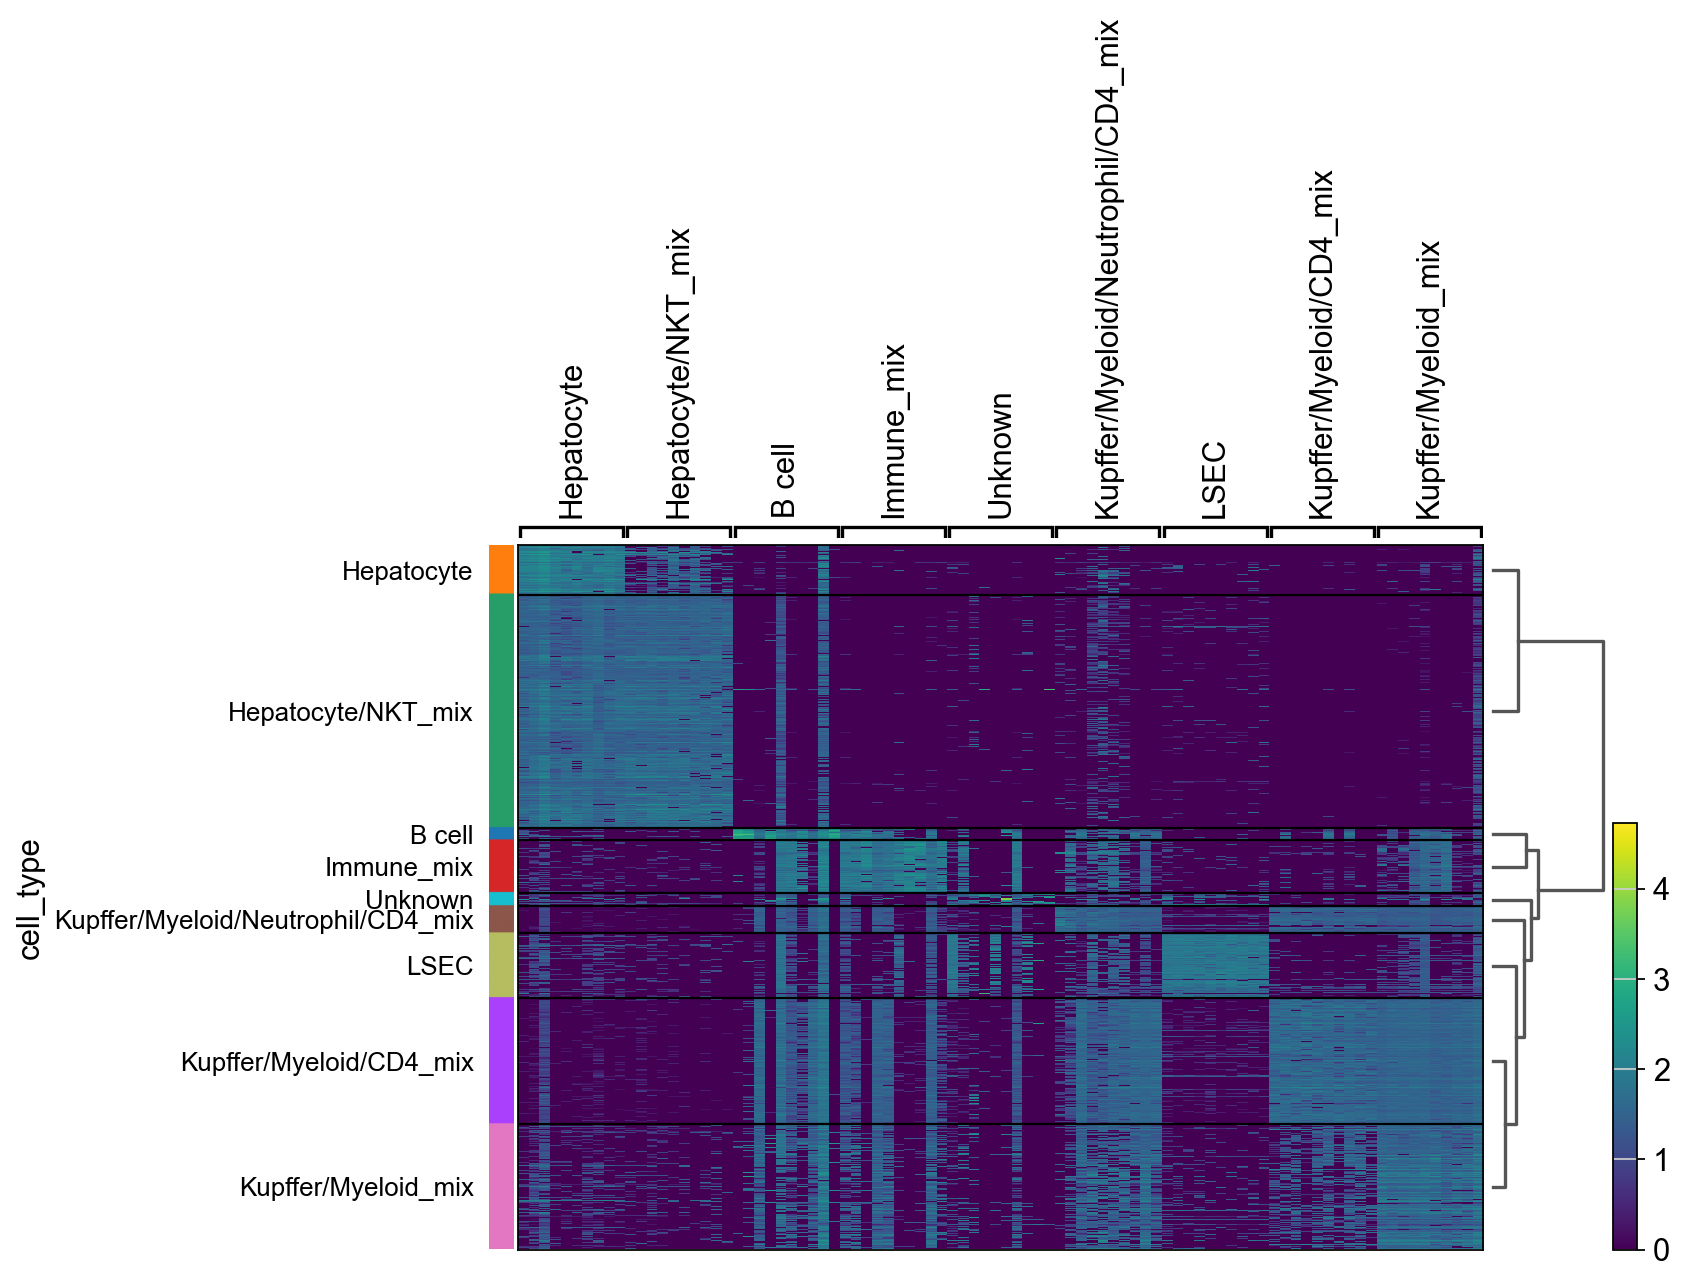

In [11]:
# --- Differentially-Expressed Genes as Markers ---
# This script uses the data-driven `rank_genes_groups` function to find the
# top genes that define each of our manually annotated cell types.

# Setup Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

# 1. Load the AnnData object with your manual cell_type annotations
adata = sc.read_h5ad('Liver_droplet_normalized_HVG_reduced_clustered_annotated.h5ad')

# 2. Create a new AnnData object that will hold the log-normalized data.
#    We initialize it with the raw counts from the 'counts' layer.
adata_log = sc.AnnData(adata.layers['counts'].copy())

# 3. CRUCIAL FIX: Copy the gene and cell names from the original object.
adata_log.var_names = adata.var_names
adata_log.obs_names = adata.obs_names

# 3. Perform normalization and log-transformation on this new object.
sc.pp.normalize_total(adata_log, target_sum=1e4)
sc.pp.log1p(adata_log)

# 4. Now, assign this correctly processed object to the .raw attribute of your main adata.
#    This aligns your object with the standard Scanpy workflow.
adata.raw = adata_log

# 2. Calculate differentially expressed genes for each annotated cell type
# This function will compare each cell type against all other cells to find
# genes that are uniquely upregulated. We use the 't-test' method here for speed.
sc.tl.rank_genes_groups(adata, groupby='cell_type', method='t-test', use_raw=True)

# 3. Visualize the top marker genes for each cell type
# This plot shows a bar chart of the top genes ranked by their score (e.g., t-statistic).
print("Displaying top marker genes for each annotated cell type:")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=True)

# 4. Create a heatmap of the top marker genes
# A heatmap can give a more detailed view of the expression patterns of the
# top defining genes across all cell types.
print("\nDisplaying heatmap of top 10 markers per cell type:")
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="cell_type", show=True)

The top differentially expressed genes from each cluster are:

- Hepatocyte: Chchd10 / Fabp1 / Dbi

Fabp1 (Fatty acid-binding protein 1) is highly specific to hepatocytes and involved in lipid metabolism and protection against oxidative injury.​

Dbi (diazepam binding inhibitor) is enriched in hepatocytes and coexpressed with Fabp1 and Apoc1 in single-cell hepatocyte clusters.​

Chchd10 is a mitochondrial protein expressed in metabolically active cells, including hepatocytes, though it is not a canonical hepatocyte marker; its co-expression with Fabp1 and Dbi supports hepatocytic identity.

- Hepatocyte/NKT_mix: Apob / Cp / Fga

Apob and Cp (ceruloplasmin) are hepatocyte-secreted plasma proteins, typical of metabolic hepatocyte function.​

Fga (fibrinogen alpha chain) is synthesized in hepatocytes as part of the coagulation system.

The “NKT mix” label likely reflects co-clustering or contamination because NKT cells express immune markers (e.g., Cd3, Nkg7) rather than hepatic secretory proteins.

- B cell: Cd79a / Cd79b / Cd74 

Cd79a, Cd79b, and Cd74 are hallmark B-lymphocyte markers.

- Immune_mix: Tmsb10 / Coro1a / Ptprcap

Tmsb10 correlates with immune infiltration, including T cells, macrophages, and endothelial immune cells.​

Coro1a (Coronin 1A) and Ptprcap (CD45-AP) are canonical leukocyte cytoskeletal and signaling genes, respectively, marking general lymphoid/myeloid identity.

- Unknown: Igfbp7 / S100a11 / Cd63

Igfbp7 is broadly expressed in hepatocytes and endothelial cells, upregulated in liver injury and fibrosis.​

S100a11 and Cd63 are expressed in various epithelial and macrophage populations, often reflecting stress or vesicle secretion, hence a mixed or transitional population designation fits.

Maybe LSEC/Hepatocyte_mix.

- Kupffer/Myeloid/Neutrophil/CD4_mix: Stmn1 / Hmgb2 / Cd74

Stmn1, Hmgb2, and Cd74 indicate proliferative myeloid/DC states.

- LSEC: Igfbp7 / Aqp1 / Clec4g

Co-expression of Ptprb, Igfbp7, Clec4g, and Aqp1 delineates endothelial clusters in liver scRNA-seq maps.​

Clec4g (LSECtin) ranks among the top LSEC-specific genes in mouse and rat liver.

- Kupffer/Myeloid/CD4_mix: Pf4 / Capg / Clec4n 

Pf4 (platelet factor 4/CXCL4) and Clec4n (DCIR2) are expressed in Kupffer and dendritic macrophages.​

Capg (actin-binding macrophage capping protein) is abundant in phagocytic myeloid cells.

- Kupffer/Myeloid_mix: Tyrobp / Ctss / Fcer1g

Tyrobp, Ctss, and Fcer1g are robust macrophage and Kupffer cell markers.


In [12]:
import gseapy as gp
import scanpy as sc
import pandas as pd
from mygene import MyGeneInfo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

In [13]:
# --- STEP 1: LOAD THE ORIGINAL DATA (ONLY ONCE!) ---
print("Loading the original annotated data...")
# Make sure the path to your file is correct
adata = sc.read_h5ad("Liver_droplet_normalized_HVG_reduced_clustered_annotated.h5ad")

# --- STEP 2: CALCULATE AND ADD THE SENMAYO SCORE ---
print("\n--- Calculating SenMayo Score ---")
# Load the mouse SenMayo gene set
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
    print(f"Loaded {len(senmayo_genes)} SenMayo genes.")
    # Compute the score and add it to adata.obs
    sc.tl.score_genes(adata, senmayo_genes, score_name='SenMayo_score')
    print("SenMayo score added to adata.obs.")
except FileNotFoundError:
    print("SAUL_SEN_MAYO.v2025.1.Mm.gmt not found. Skipping SenMayo score calculation.")


# --- STEP 3: CALCULATE AND ADD THE CELLAGE SCORE ---
print("\n--- Calculating CellAge Score ---")
# Load CellAge data and extract human genes that induce senescence
try:
    cellage_df = pd.read_csv("cellage3.tsv", sep="\t")
    human_cellage_genes = cellage_df.loc[cellage_df["Senescence Effect"] == "Induces", "Gene symbol"].tolist()
    print(f"Extracted {len(human_cellage_genes)} human genes from CellAge.")

    # Convert human genes to mouse orthologs (symbols)
    print("Finding mouse orthologs for CellAge genes...")
    mg = MyGeneInfo()
    # First, get NCBI IDs
    human_query = mg.querymany(human_cellage_genes, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_gene_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090: # Mouse taxon ID
                    mouse_gene_ids.append(g[1])
    mouse_gene_ids = sorted(list(set(mouse_gene_ids)))
    # Second, convert NCBI IDs to symbols
    mouse_gene_info = mg.getgenes(mouse_gene_ids, fields='symbol', verbose=False)
    mouse_cellage_genes = [info['symbol'] for info in mouse_gene_info if 'symbol' in info]
    print(f"Converted to {len(mouse_cellage_genes)} mouse ortholog symbols.")

    # Compute the score and add it to the SAME adata.obs
    sc.tl.score_genes(adata, mouse_cellage_genes, score_name='CellAge_up_score')
    print("CellAge score added to adata.obs.")
except FileNotFoundError:
    print("cellage3.tsv not found. Skipping CellAge score calculation.")


# --- STEP 4: CALCULATE AND ADD HERNANDEZ SEGURA SCORES ---
print("\n--- Calculating Hernandez Segura Scores ---")
# Define the human gene lists from the image
hernandez_segura_enriched_human = [
    'ACADVL', 'ADPGK', 'B4GALT7', 'BCL2L2', 'CCND1', 'CHMP5', 'DDA1', 'DGKA',
    'DYNLT3', 'FAM214B', 'GBE1', 'GDNF', 'KLC1', 'MT-CYB', 'NOL3', 'P4HA2',
    'PDLIM4', 'PLK3', 'PLXNA3', 'POFUT2', 'RAI14', 'SCOC', 'SLC10A3', 'SLC16A3',
    'SUSD6', 'TAF13', 'TMEM87B', 'TOLLIP', 'TSPAN13', 'UFM1', 'ZBTB7A', 'ZNHIT1'
]
hernandez_segura_depleted_human = [
    'ARHGAP35', 'ARID2', 'ASCC1', 'C2CD5', 'CNTLN', 'CREBBP', 'EFNB3', 'GSTM4',
    'ICE1', 'KCTD3', 'MEIS1', 'NFIA', 'PATZ1', 'PCIF1', 'PDS5B', 'RHNO1', 'SMO',
    'SPATA6', 'SPIN4', 'STAG1', 'TRDMT1', 'USP6NL', 'ZC3H4'
]
print(f"Defined Hernandez Segura signature with {len(hernandez_segura_enriched_human)} enriched and {len(hernandez_segura_depleted_human)} depleted human genes.")

# Initialize MyGeneInfo client if not already done
if 'mg' not in locals():
    mg = MyGeneInfo()

# Function to convert human gene symbols to mouse orthologs
def convert_human_to_mouse(gene_list):
    human_query = mg.querymany(gene_list, scopes="symbol", species="human", fields="homologene", verbose=False)
    mouse_ids = []
    for item in human_query:
        if isinstance(item.get('homologene'), dict) and 'genes' in item['homologene']:
            for g in item["homologene"]["genes"]:
                if g[0] == 10090:  # Mouse taxon ID
                    mouse_ids.append(g[1])
    mouse_ids = sorted(list(set(mouse_ids)))
    mouse_info = mg.getgenes(mouse_ids, fields='symbol', verbose=False)
    mouse_symbols = [info['symbol'] for info in mouse_info if 'symbol' in info]
    return mouse_symbols

# Convert both lists
print("Finding mouse orthologs for Hernandez Segura genes...")
mouse_hernandez_enriched = convert_human_to_mouse(hernandez_segura_enriched_human)
mouse_hernandez_depleted = convert_human_to_mouse(hernandez_segura_depleted_human)
print(f"Converted to {len(mouse_hernandez_enriched)} enriched and {len(mouse_hernandez_depleted)} depleted mouse orthologs.")

# Compute and add the scores to adata.obs
sc.tl.score_genes(adata, mouse_hernandez_enriched, score_name='HernandezSegura_enriched_score')
print("HernandezSegura_enriched_score added to adata.obs.")
sc.tl.score_genes(adata, mouse_hernandez_depleted, score_name='HernandezSegura_depleted_score')
print("HernandezSegura_depleted_score added to adata.obs.")


# --- STEP 5: VERIFY AND SAVE THE FINAL OBJECT ---
print("\n--- Verification and Saving ---")
# Verify that ALL score columns are now in adata.obs
print("Columns in adata.obs now include:", adata.obs.columns.tolist())
# Save the final object containing ALL scores to a new file
output_filename = "Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"
adata.write_h5ad(output_filename)
print(f"\nSuccessfully saved AnnData object with ALL scores to '{output_filename}'")

Loading the original annotated data...

--- Calculating SenMayo Score ---
Loaded 117 SenMayo genes.
computing score 'SenMayo_score'
    finished: added
    'SenMayo_score', score of gene set (adata.obs).
    1092 total control genes are used. (0:00:00)


SenMayo score added to adata.obs.

--- Calculating CellAge Score ---
Extracted 417 human genes from CellAge.
Finding mouse orthologs for CellAge genes...


Converted to 366 mouse ortholog symbols.
computing score 'CellAge_up_score'
       'Ifi207', 'Ifi209', 'Tigar', 'Ccn6', 'Ifi211', 'Atraid', 'Ifi214',
       'Ifi213', 'Ifi208', 'Bnip3l-ps', 'Ifi203-ps', 'Ifi206'],
      dtype='object')
    finished: added
    'CellAge_up_score', score of gene set (adata.obs).
    1071 total control genes are used. (0:00:00)


CellAge score added to adata.obs.

--- Calculating Hernandez Segura Scores ---
Defined Hernandez Segura signature with 32 enriched and 23 depleted human genes.
Finding mouse orthologs for Hernandez Segura genes...


Converted to 31 enriched and 21 depleted mouse orthologs.
computing score 'HernandezSegura_enriched_score'
    finished: added
    'HernandezSegura_enriched_score', score of gene set (adata.obs).
    599 total control genes are used. (0:00:00)
HernandezSegura_enriched_score added to adata.obs.
computing score 'HernandezSegura_depleted_score'
    finished: added
    'HernandezSegura_depleted_score', score of gene set (adata.obs).
    648 total control genes are used. (0:00:00)
HernandezSegura_depleted_score added to adata.obs.

--- Verification and Saving ---
Columns in adata.obs now include: ['age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_

As expected, since droplet misses a lot of depth the signatures will also miss more genes than in the facs data. Here the signatures missed 3, 20 and 5 genes for SenMayo, CellAge and Hernandez-Segura (both enriched and depleted).

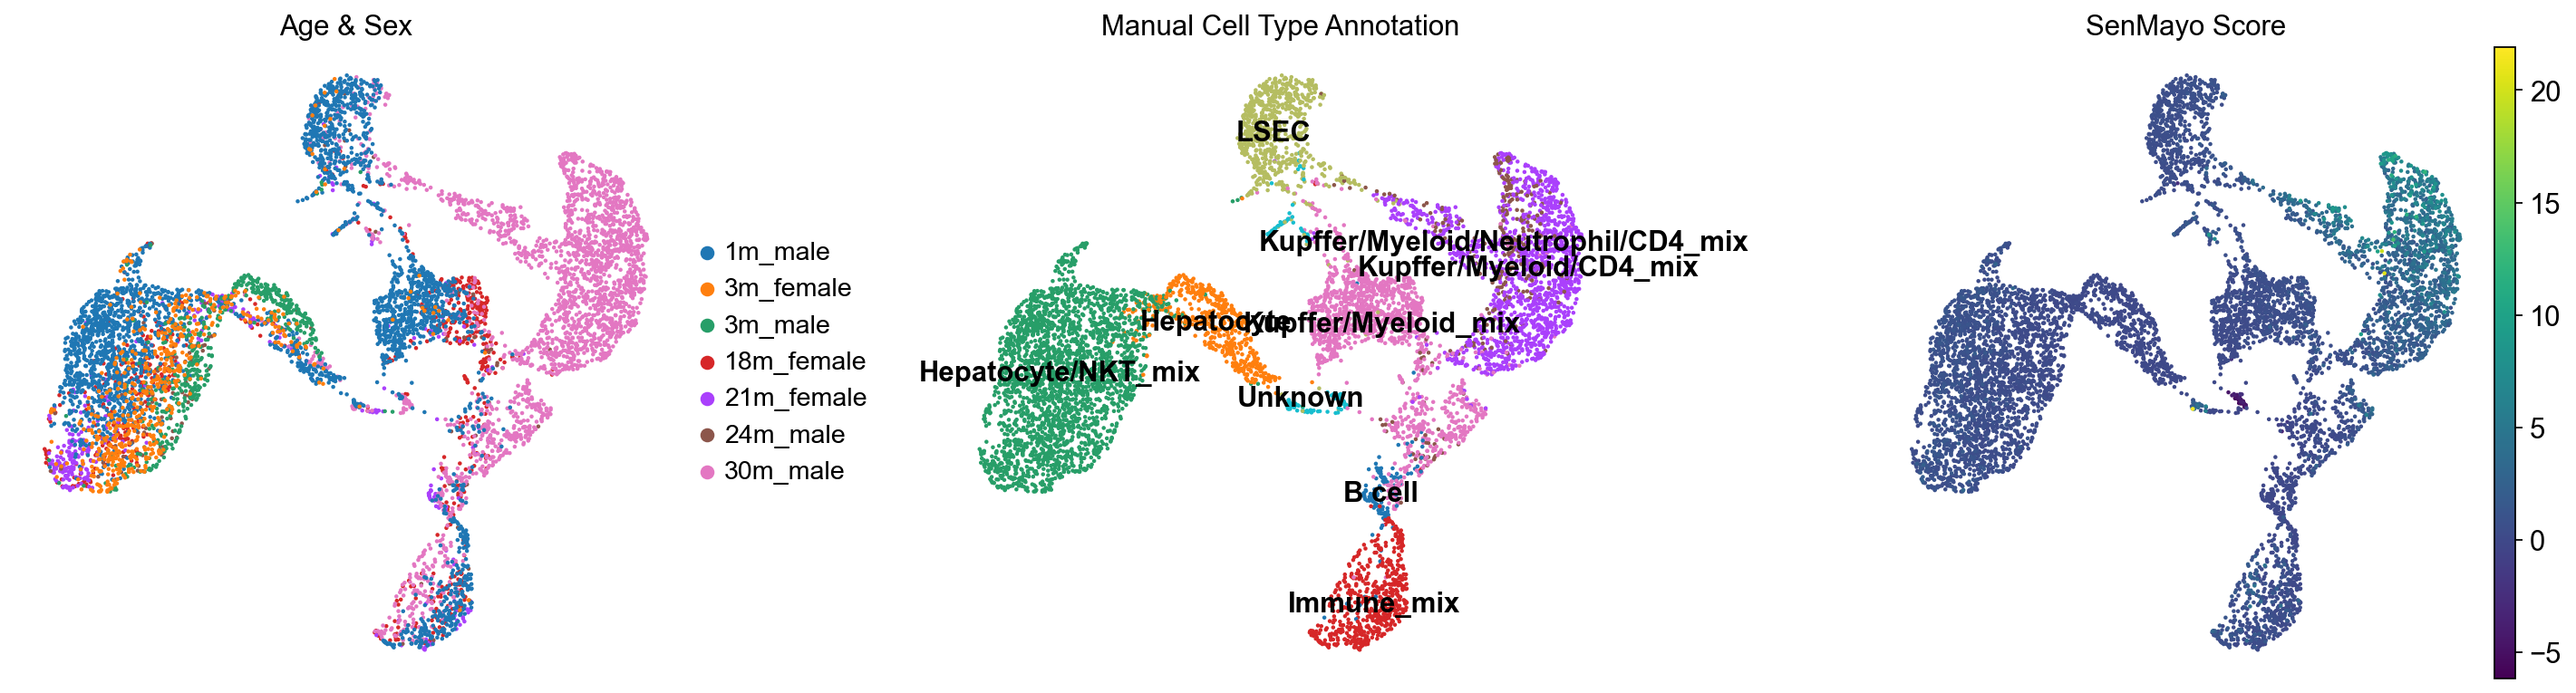

In [14]:
# Visualize
# 1. Create a figure and a 1x3 grid of subplots (one row, three columns).
# We'll make the figure wider to accommodate the side-by-side plots.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2. Plot each UMAP on a specific subplot (ax).
# The 'axes' object is now a simple list, so we access subplots with a single index.
# We use show=False to prevent each plot from displaying individually.

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0], # Target the first subplot
    show=False,
    legend_loc='right margin', # Legend on the right
    title='Age & Sex'
)

# Second plot (middle): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1], # Target the second subplot
    show=False,
    legend_loc='on data',
    title='Manual Cell Type Annotation'
)

# Third plot (right): SenMayo score
sc.pl.umap(
    adata,
    color='SenMayo_score',
    ax=axes[2], # Target the third subplot
    show=False,
    cmap='viridis',
    title='SenMayo Score'
)

# 3. Adjust spacing and display the final composite figure
plt.tight_layout()
plt.show()

For the visual inspection it seems like there are more cells predicted as senescent than in the facs data, which again is to be expected. It also looks like they exhibit a stronger signal but that is due to the format of the graph, in reality these cells present around the same levels of SenMayo score as the facs cells.

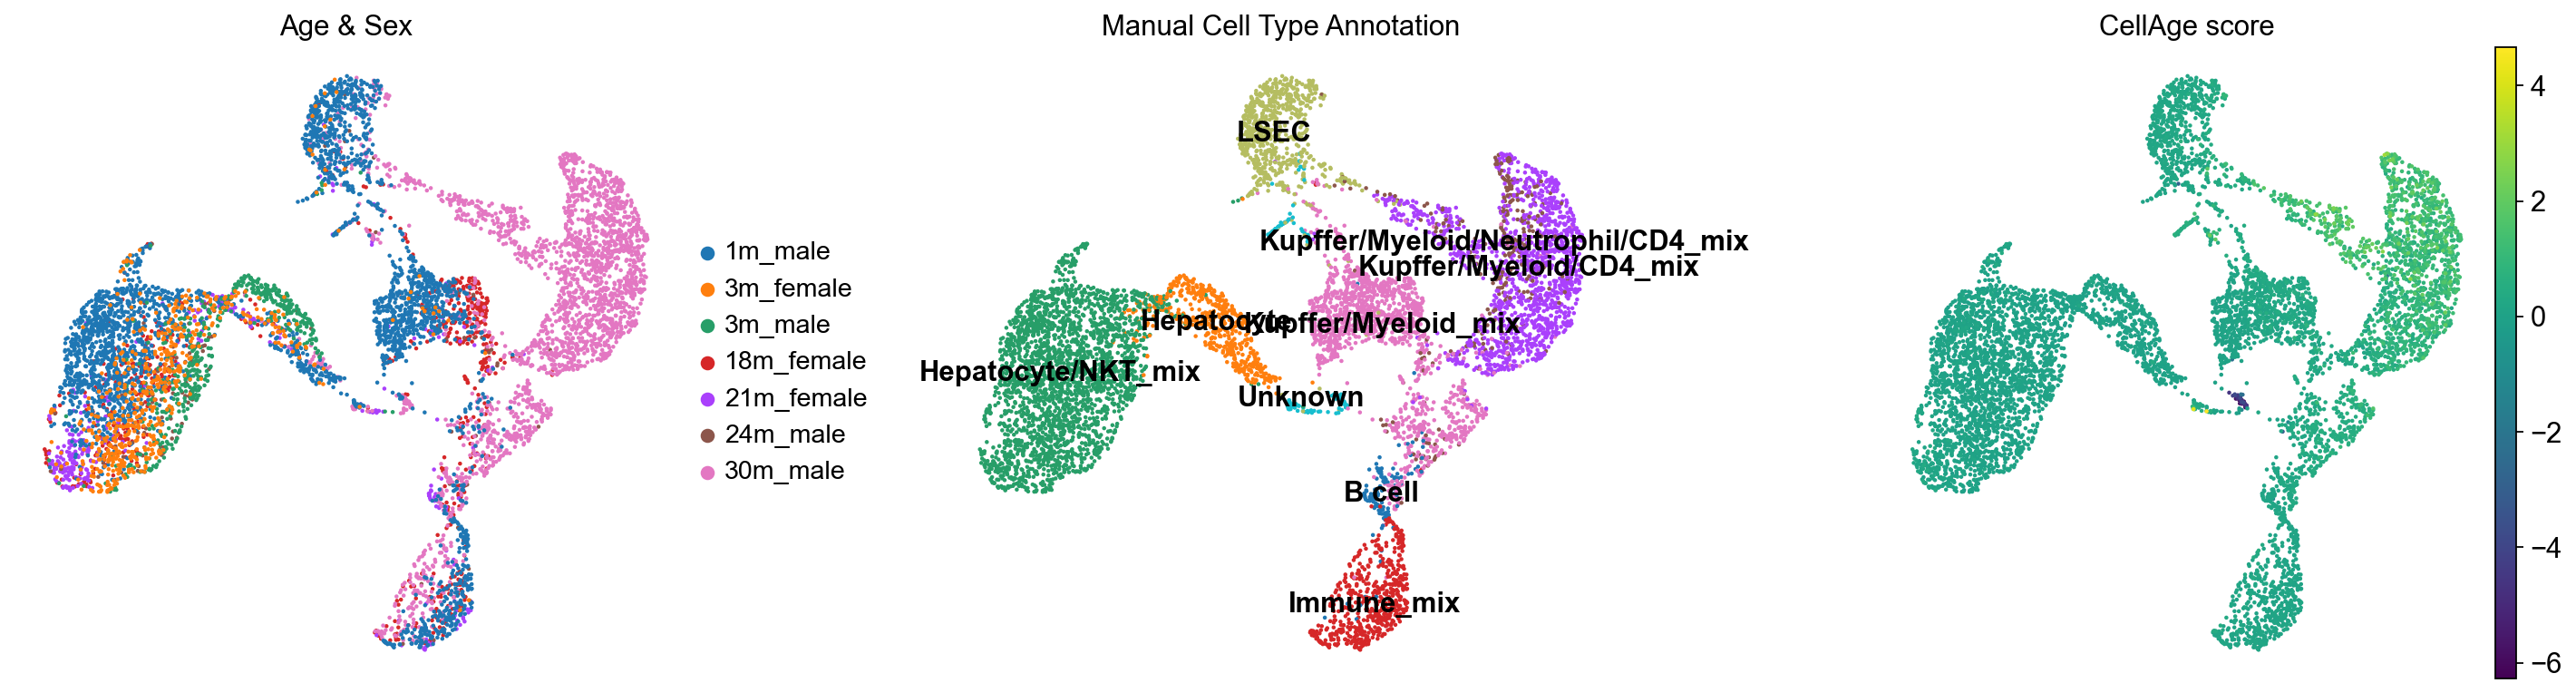

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0], # Target the first subplot
    show=False,
    legend_loc='right margin', # Legend on the right
    title='Age & Sex'
)

# Second plot (middle): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1], # Target the second subplot
    show=False,
    legend_loc='on data',
    title='Manual Cell Type Annotation'
)

# Third plot (right): SenMayo score
sc.pl.umap(
    adata,
    color='CellAge_up_score',
    ax=axes[2], # Target the third subplot
    show=False,
    cmap='viridis',
    title='CellAge score'
)

# 3. Adjust spacing and display the final composite figure
plt.tight_layout()
plt.show()

It seems like the same cells are being identified as senescent, although because of the formating I'm not so sure.

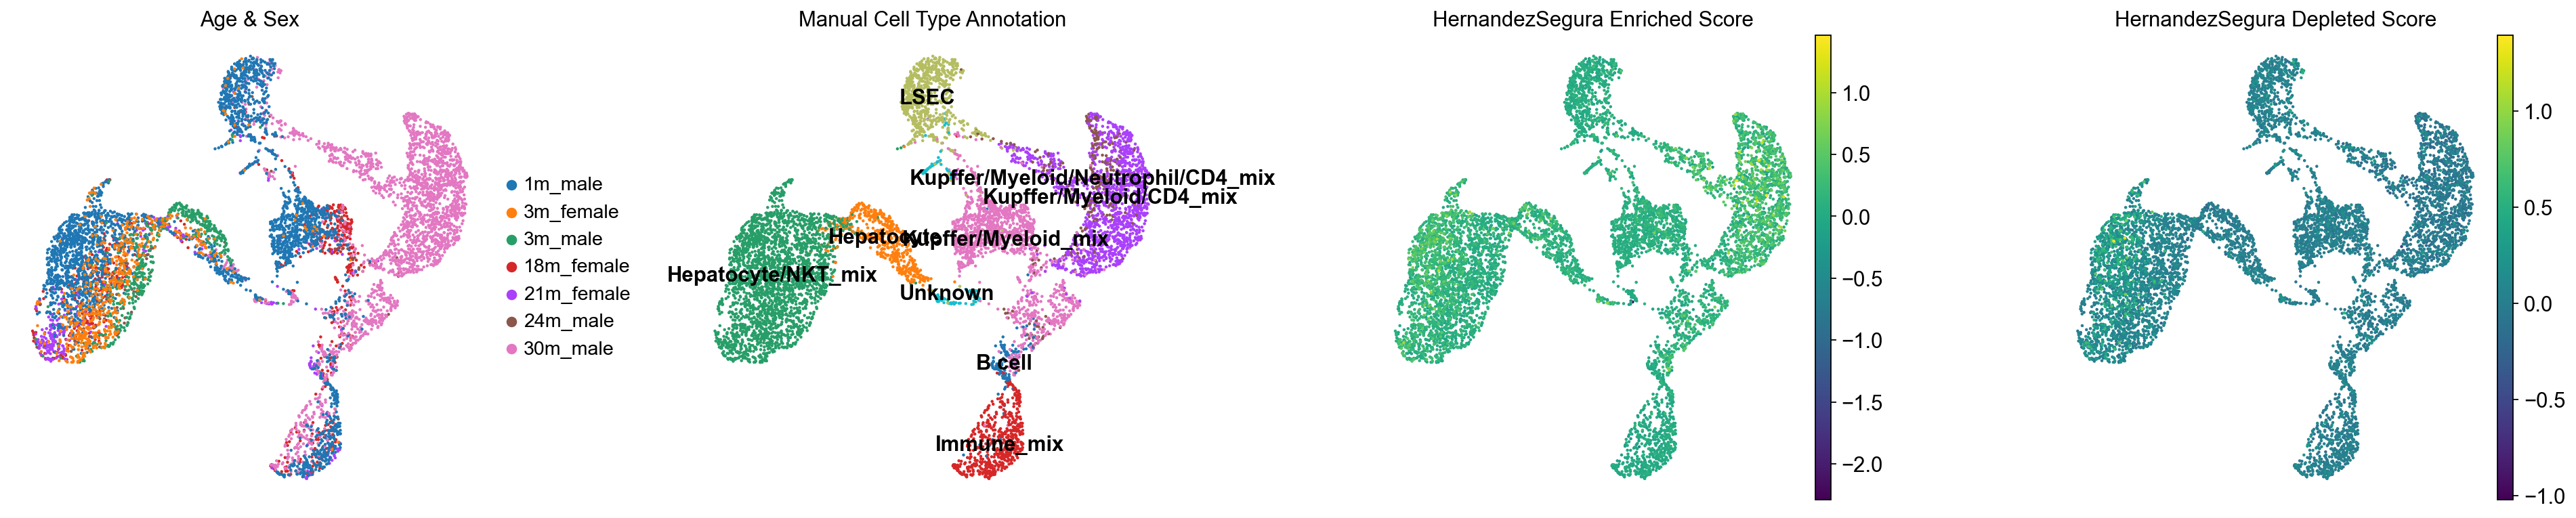

In [16]:
# 1. Create a figure with 4 subplots in a single row.
# Increased the figsize width to accommodate the extra plot.
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# 2. Plot each UMAP on its specific subplot (ax).

# First plot (left): Age and Sex
sc.pl.umap(
    adata,
    color='age_sex',
    ax=axes[0],
    show=False,
    legend_loc='right margin',
    title='Age & Sex'
)

# Second plot (middle-left): Manual cell type annotation
sc.pl.umap(
    adata,
    color='cell_type',
    ax=axes[1],
    show=False,
    # 'on data' can get crowded, 'right margin' might be better if you have many types.
    legend_loc='on data', 
    title='Manual Cell Type Annotation'
)

# Third plot (middle-right): HernandezSegura Enriched Score
sc.pl.umap(
    adata,
    color='HernandezSegura_enriched_score', # Plot only the enriched score here
    ax=axes[2],
    show=False,
    cmap='viridis', # 'viridis' is a good choice for continuous scores
    title='HernandezSegura Enriched Score' # Corrected title
)

# Fourth plot (right): HernandezSegura Depleted Score
sc.pl.umap(
    adata,
    color='HernandezSegura_depleted_score', # Plot only the depleted score here
    ax=axes[3],
    show=False,
    cmap='viridis',
    title='HernandezSegura Depleted Score'
)

# 3. Adjust spacing and display the final composite figure.
plt.tight_layout()
plt.show()

Looks like there is a better signal for the enriched Hernandez Segura genes than the depleted ones.

--- Defining consistent thresholds for all analyses ---
Thresholds set: SenMayo > 1.5, CellAge > 0.5, Hernandez > 0.25

Total number of cells above each threshold:
is_high_SenMayo      1438
is_high_CellAge      1552
is_high_Hernandez    1123
dtype: int64
---------------------------------------------------------

--- Running Part 3: Analysis of All Three Signatures ---

Cell Counts (3 Signatures):
senescence_category_3
Low in All              5213
High in 1 Signature      720
High in 2 Signatures     690
High in All 3            671
Name: count, dtype: int64
---------------------------------------------------------
Generating the second plot...


<Figure size 960x1440 with 0 Axes>

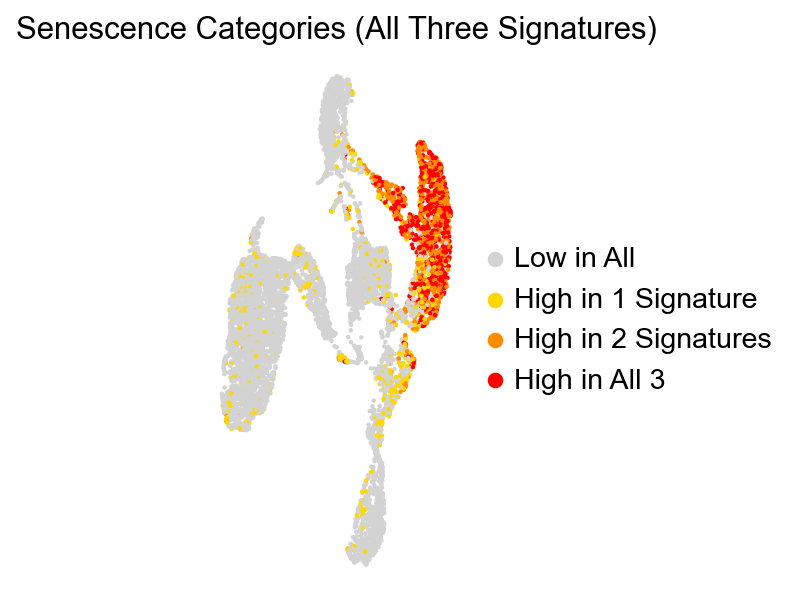


--- Saving the updated AnnData object with consistent flags ---
Successfully saved updated data to 'Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad'


In [17]:
# --- Step 1: Load the data containing ALL scores ---
adata = sc.read_h5ad("Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# ---------------------------------------------------------------------------
# --- PART 1: DEFINE PARAMETERS AND CREATE BOOLEAN FLAGS ---
# All thresholds are defined ONCE here for consistency across the entire script.
# ---------------------------------------------------------------------------
print("--- Defining consistent thresholds for all analyses ---")
# These values are set slightly above the 75th percentile to capture high-scoring cells.
senmayo_threshold = 1.5
cellage_threshold = 0.5
hernandez_threshold = 0.25

# Create the combined Hernandez score first
adata.obs['HernandezSegura_combined_score'] = adata.obs['HernandezSegura_enriched_score'] - adata.obs['HernandezSegura_depleted_score']

# Create and store a single set of boolean flags to be used everywhere
adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold
adata.obs['is_high_CellAge'] = adata.obs['CellAge_up_score'] > cellage_threshold
adata.obs['is_high_Hernandez'] = adata.obs['HernandezSegura_combined_score'] > hernandez_threshold

print(f"Thresholds set: SenMayo > {senmayo_threshold}, CellAge > {cellage_threshold}, Hernandez > {hernandez_threshold}")
print("\nTotal number of cells above each threshold:")
print(adata.obs[['is_high_SenMayo', 'is_high_CellAge', 'is_high_Hernandez']].sum())
print("---------------------------------------------------------")

# ---------------------------------------------------------------------------
# --- PART 3: ANALYSIS of All Three Signatures ---
# ---------------------------------------------------------------------------
print("\n--- Running Part 3: Analysis of All Three Signatures ---")

# Use the boolean flags to sum the conditions met by each cell
sum_of_conditions = adata.obs['is_high_SenMayo'].astype(int) + \
                    adata.obs['is_high_CellAge'].astype(int) + \
                    adata.obs['is_high_Hernandez'].astype(int)

# Create the 3-signature categorical column
adata.obs['senescence_category_3'] = 'Low in All'
adata.obs.loc[sum_of_conditions == 1, 'senescence_category_3'] = 'High in 1 Signature'
adata.obs.loc[sum_of_conditions == 2, 'senescence_category_3'] = 'High in 2 Signatures'
adata.obs.loc[sum_of_conditions == 3, 'senescence_category_3'] = 'High in All 3'

adata.obs['senescence_category_3'] = pd.Categorical(
    adata.obs['senescence_category_3'],
    categories=['Low in All', 'High in 1 Signature', 'High in 2 Signatures', 'High in All 3'], ordered=True)

print("\nCell Counts (3 Signatures):")
print(adata.obs['senescence_category_3'].value_counts())
print("---------------------------------------------------------")

# Visualize the 3-score categories on a UMAP plot
print("Generating the second plot...")
plt.figure(figsize=(12, 18))
sc.pl.umap(adata, color='senescence_category_3', title='Senescence Categories (All Three Signatures)',
           palette={'Low in All': 'lightgrey', 'High in 1 Signature': 'gold', 'High in 2 Signatures': 'darkorange', 'High in All 3': 'red'}, show=False)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# --- PART 4: SAVE THE FINAL ANNDATA OBJECT ---
# ---------------------------------------------------------------------------
print("\n--- Saving the updated AnnData object with consistent flags ---")
output_filename = "Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"
adata.write_h5ad(output_filename)
print(f"Successfully saved updated data to '{output_filename}'")

Here in the droplet data we still use the 75% percentile as an indicator but I set the threshold a bit higher due to the sheer amount of cells in comparison to the facs data. 

We also see an increase in the overall number of cells identified as senescent by all three signatures, as well as the amount of cells that are identified as senescent by 2 or more signatures at once. Even though the depth is lower in this data it seems like the signatures concur more on the classification of senescence. What does this mean? I dont really know..

In [18]:
# 1. Get descriptive statistics for each score
print("\nStatistics for SenMayo_score:")
print(adata.obs['SenMayo_score'].describe())

print("\nStatistics for CellAge_up_score:")
print(adata.obs['CellAge_up_score'].describe())

print("\nStatistics for HernandezSegura_combined_score:")
print(adata.obs['HernandezSegura_combined_score'].describe())


Statistics for SenMayo_score:
count    7294.000000
mean        1.004367
std         1.630055
min        -6.173125
25%         0.187018
50%         0.451200
75%         1.028051
max        21.932813
Name: SenMayo_score, dtype: float64

Statistics for CellAge_up_score:
count    7294.000000
mean        0.283247
std         0.573922
min        -6.274861
25%         0.032324
50%         0.132080
75%         0.388413
max         4.662246
Name: CellAge_up_score, dtype: float64

Statistics for HernandezSegura_combined_score:
count    7294.000000
mean        0.067509
std         0.221454
min        -2.265667
25%        -0.051634
50%         0.040231
75%         0.157848
max         1.863802
Name: HernandezSegura_combined_score, dtype: float64


FACS Data: Your FACS data likely has much deeper sequencing per cell. More UMIs per cell means the expression values for the genes in your signature lists are higher. When score_genes averages these values, the resulting score is naturally much larger. The mean SenMayo score of ~80 and max of ~3700 is indicative of high overall counts.

Droplet Data: Droplet-based methods (like 10x) often have shallower sequencing per cell compared to plate-based or sorted methods. With fewer UMIs per cell, the gene expression values are lower, leading to numerically smaller scores. The mean SenMayo score of ~1 and max of ~22 is typical for this kind of data.

Even if the depth is lower for this droplet data it seems that the number of cells identified as senescent by our signatures is much larger. 

In [19]:
# --- Step 1: Load the data ---
adata = sc.read_h5ad("Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# ---------------------------------------------------------------------------
# --- UNIFIED THRESHOLD DEFINITION ---
# Define thresholds ONCE and use them for all analyses.
# ---------------------------------------------------------------------------
print("--- Defining consistent thresholds for all analyses ---")
# These values are set slightly above the 75th percentile to capture high-scoring cells.
senmayo_threshold = 1.5
cellage_threshold = 0.5
hernandez_threshold = 0.25

# Create the boolean flags ONCE
adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold
adata.obs['is_high_CellAge'] = adata.obs['CellAge_up_score'] > cellage_threshold

# Create the combined Hernandez score and its flag
adata.obs['HernandezSegura_combined_score'] = adata.obs['HernandezSegura_enriched_score'] - adata.obs['HernandezSegura_depleted_score']
adata.obs['is_high_Hernandez'] = adata.obs['HernandezSegura_combined_score'] > hernandez_threshold

print(f"Thresholds set: SenMayo > {senmayo_threshold}, CellAge > {cellage_threshold}, Hernandez > {hernandez_threshold}")
print("---------------------------------------------------------")

# ---------------------------------------------------------------------------
# --- PART 2: ANALYSIS (All Three Signatures) ---
# This part already worked, but now it explicitly uses the pre-defined flags.
# ---------------------------------------------------------------------------
print("\n--- Running Part 2: Crosstab for All Three Signatures ---")

sum_of_conditions = adata.obs['is_high_SenMayo'].astype(int) + \
                    adata.obs['is_high_CellAge'].astype(int) + \
                    adata.obs['is_high_Hernandez'].astype(int)

# --- Create the new categorical column for the 3-score comparison ---
adata.obs['senescence_category_3'] = 'Low in All'
adata.obs.loc[sum_of_conditions == 1, 'senescence_category_3'] = 'High in 1 Signature'
adata.obs.loc[sum_of_conditions == 2, 'senescence_category_3'] = 'High in 2 Signatures'
adata.obs.loc[sum_of_conditions == 3, 'senescence_category_3'] = 'High in All 3'

# --- Create and print the crosstab tables for the 3-score comparison ---
contingency_table_3 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_3']
)
print("\n--- Absolute Count of Cells (3 Signatures) ---")
print(contingency_table_3)
print("-----------------------------------------------\n")

proportion_table_3 = pd.crosstab(
    adata.obs['age_sex'], 
    adata.obs['senescence_category_3'], 
    normalize='index'
).multiply(100).round(2)
print("--- Normalized proportions of Cells (3 Signatures, within each age_sex group) ---")
print(proportion_table_3)
print("---------------------------------------------------------------------\n")

--- Defining consistent thresholds for all analyses ---
Thresholds set: SenMayo > 1.5, CellAge > 0.5, Hernandez > 0.25
---------------------------------------------------------

--- Running Part 2: Crosstab for All Three Signatures ---

--- Absolute Count of Cells (3 Signatures) ---
senescence_category_3  High in 1 Signature  High in 2 Signatures  \
age_sex                                                            
1m_male                                215                    10   
3m_female                               31                     0   
3m_male                                 51                     1   
18m_female                              32                     1   
21m_female                              50                     5   
24m_male                                15                     8   
30m_male                               326                   665   

senescence_category_3  High in All 3  Low in All  
age_sex                                           
1

As we can see the largest ratio of senescent cells identified by all three signatures is from the 30 month male, also a good result considering the context. And this could also explain how there is such corroboration between signatures of the senescent cell classification.

--- Defining senescent population based on data-driven threshold for DROPLET data ---
Analysis will be performed on the 1438 cells identified as high in the SenMayo signature.

Top 10 most frequently expressed SenMayo genes WITHIN High-SenMayo Cells:
         gene  percent_expressing
28     Cxcl16           91.794159
14       Ccl4           91.515994
24       Ctsb           91.237830
45       Gmfg           90.681502
74       Lcp1           90.681502
63       Il1b           90.681502
106  Tnfrsf1a           90.194715
5         Axl           89.777469
61       Il18           89.290682
43      Gdf15           88.734353


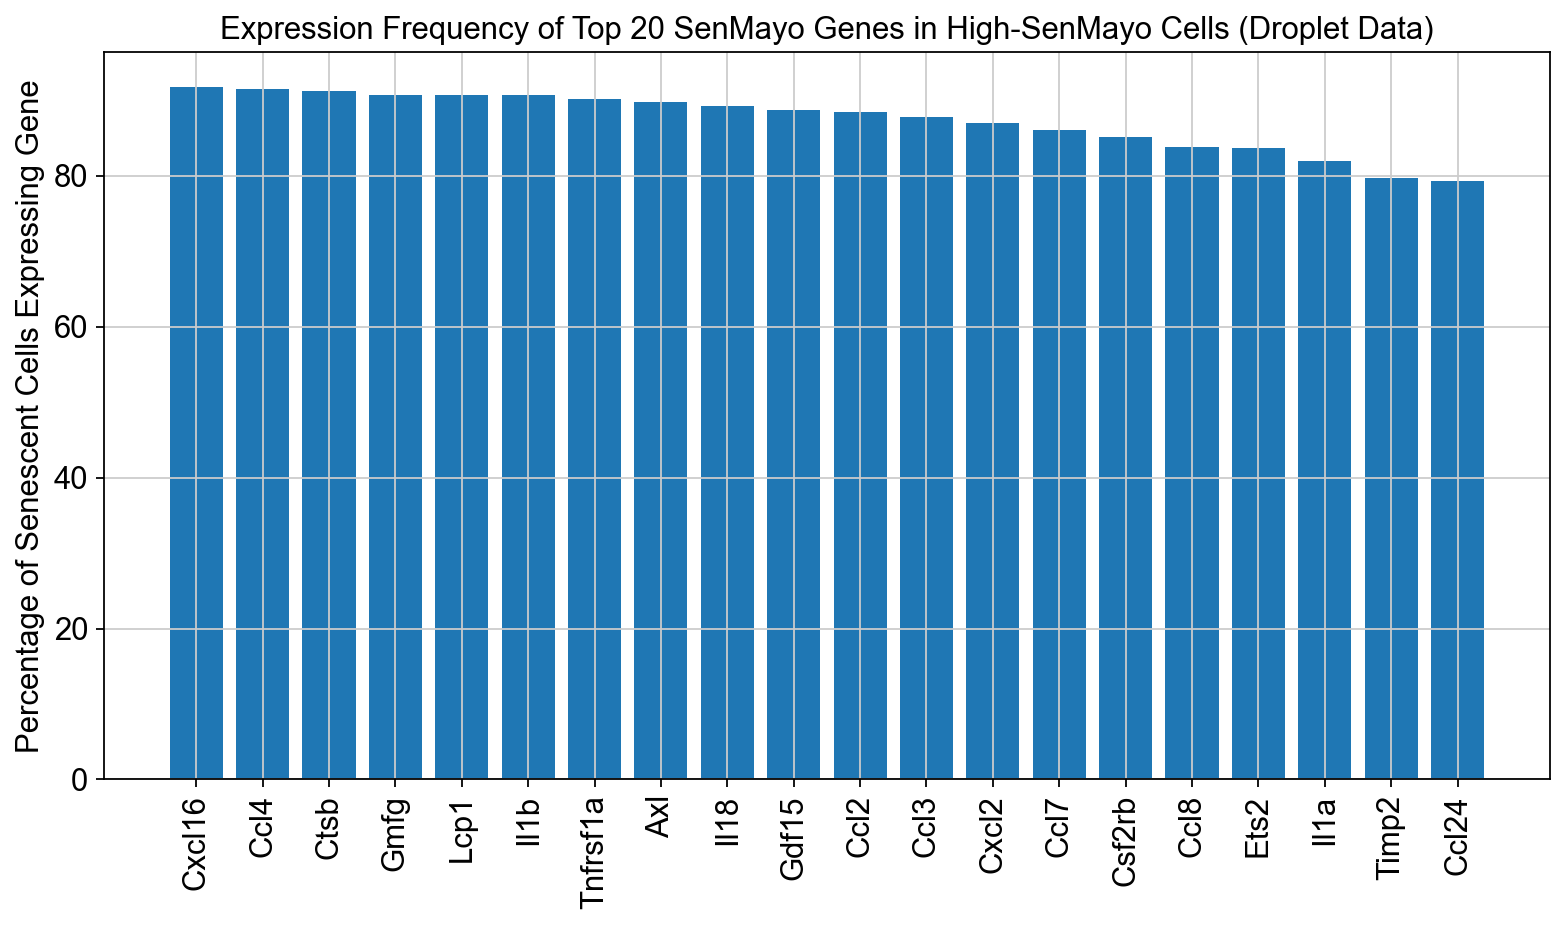

In [23]:
# --- Step 1: Load the data and DEFINE the senescent cell population ---
adata = sc.read_h5ad("Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# Define which cells are "high in SenMayo" using the data-driven threshold.
print("--- Defining senescent population based on data-driven threshold for DROPLET data ---")

# --- THIS IS THE FIX ---
# CORRECTED: Using the threshold derived from the DROPLET data's 75th percentile (~1.03)
senmayo_threshold = 1.5 
# ---------------------

adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold

# Create a boolean mask to select ONLY the cells that meet our criteria.
senescent_cell_mask = adata.obs['is_high_SenMayo'] == True

# Check how many cells we are analyzing.
num_senescent_cells = senescent_cell_mask.sum()
if num_senescent_cells == 0:
    print("Warning: No cells were identified as high in the SenMayo signature. Cannot proceed.")
else:
    print(f"Analysis will be performed on the {num_senescent_cells} cells identified as high in the SenMayo signature.")

    # --- Step 2: Analyze gene expression ONLY within the senescent subset ---
    try:
        senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
        senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
    except FileNotFoundError:
        print("SAUL_SEN_MAYO.v2025.1.Mm.gmt not found. Please ensure the file is in the correct path.")
        senmayo_genes = []

    if senmayo_genes:
        # Ensure we only consider genes present in our dataset
        senmayo_genes_in_adata = [gene for gene in senmayo_genes if gene in adata.var_names]

        # We apply the 'senescent_cell_mask' to the rows (cells) before getting expression data.
        senmayo_expression_subset = adata[senescent_cell_mask, senmayo_genes_in_adata].X

        # Handle sparse vs. dense matrix formats
        if scipy.sparse.issparse(senmayo_expression_subset):
            expression_dense = senmayo_expression_subset.toarray()
        else:
            expression_dense = senmayo_expression_subset

        # Calculate the percentage of SENESCENT cells with non-zero reads for each gene
        percent_expressing = (expression_dense > 0).mean(axis=0) * 100

        # Create a DataFrame for easy viewing and sorting
        percent_expressing_df = pd.DataFrame({
            'gene': senmayo_genes_in_adata,
            'percent_expressing': percent_expressing
        }).sort_values(by='percent_expressing', ascending=False)

        print("\nTop 10 most frequently expressed SenMayo genes WITHIN High-SenMayo Cells:")
        print(percent_expressing_df.head(10))

        # Visualize the results
        plt.figure(figsize=(10, 6))
        top_genes_df = percent_expressing_df.head(20)
        plt.bar(top_genes_df['gene'], top_genes_df['percent_expressing'])
        plt.xticks(rotation=90)
        plt.ylabel("Percentage of Senescent Cells Expressing Gene")
        plt.title("Expression Frequency of Top 20 SenMayo Genes in High-SenMayo Cells (Droplet Data)")
        plt.tight_layout()
        plt.show()

These are much higher overall percentages of SenMayo genes than in the facs data.

--- Defining senescent population based on data-driven threshold for DROPLET data ---
Found 1438 cells with SenMayo score > 1.5

--- Identifying the top 20 most expressed SenMayo genes ---
Top 20 SenMayo genes identified.

--- Subsetting for the 1438 high SenMayo cells ---

--- Calculating expression percentages within age groups ---

--- Generating plot ---


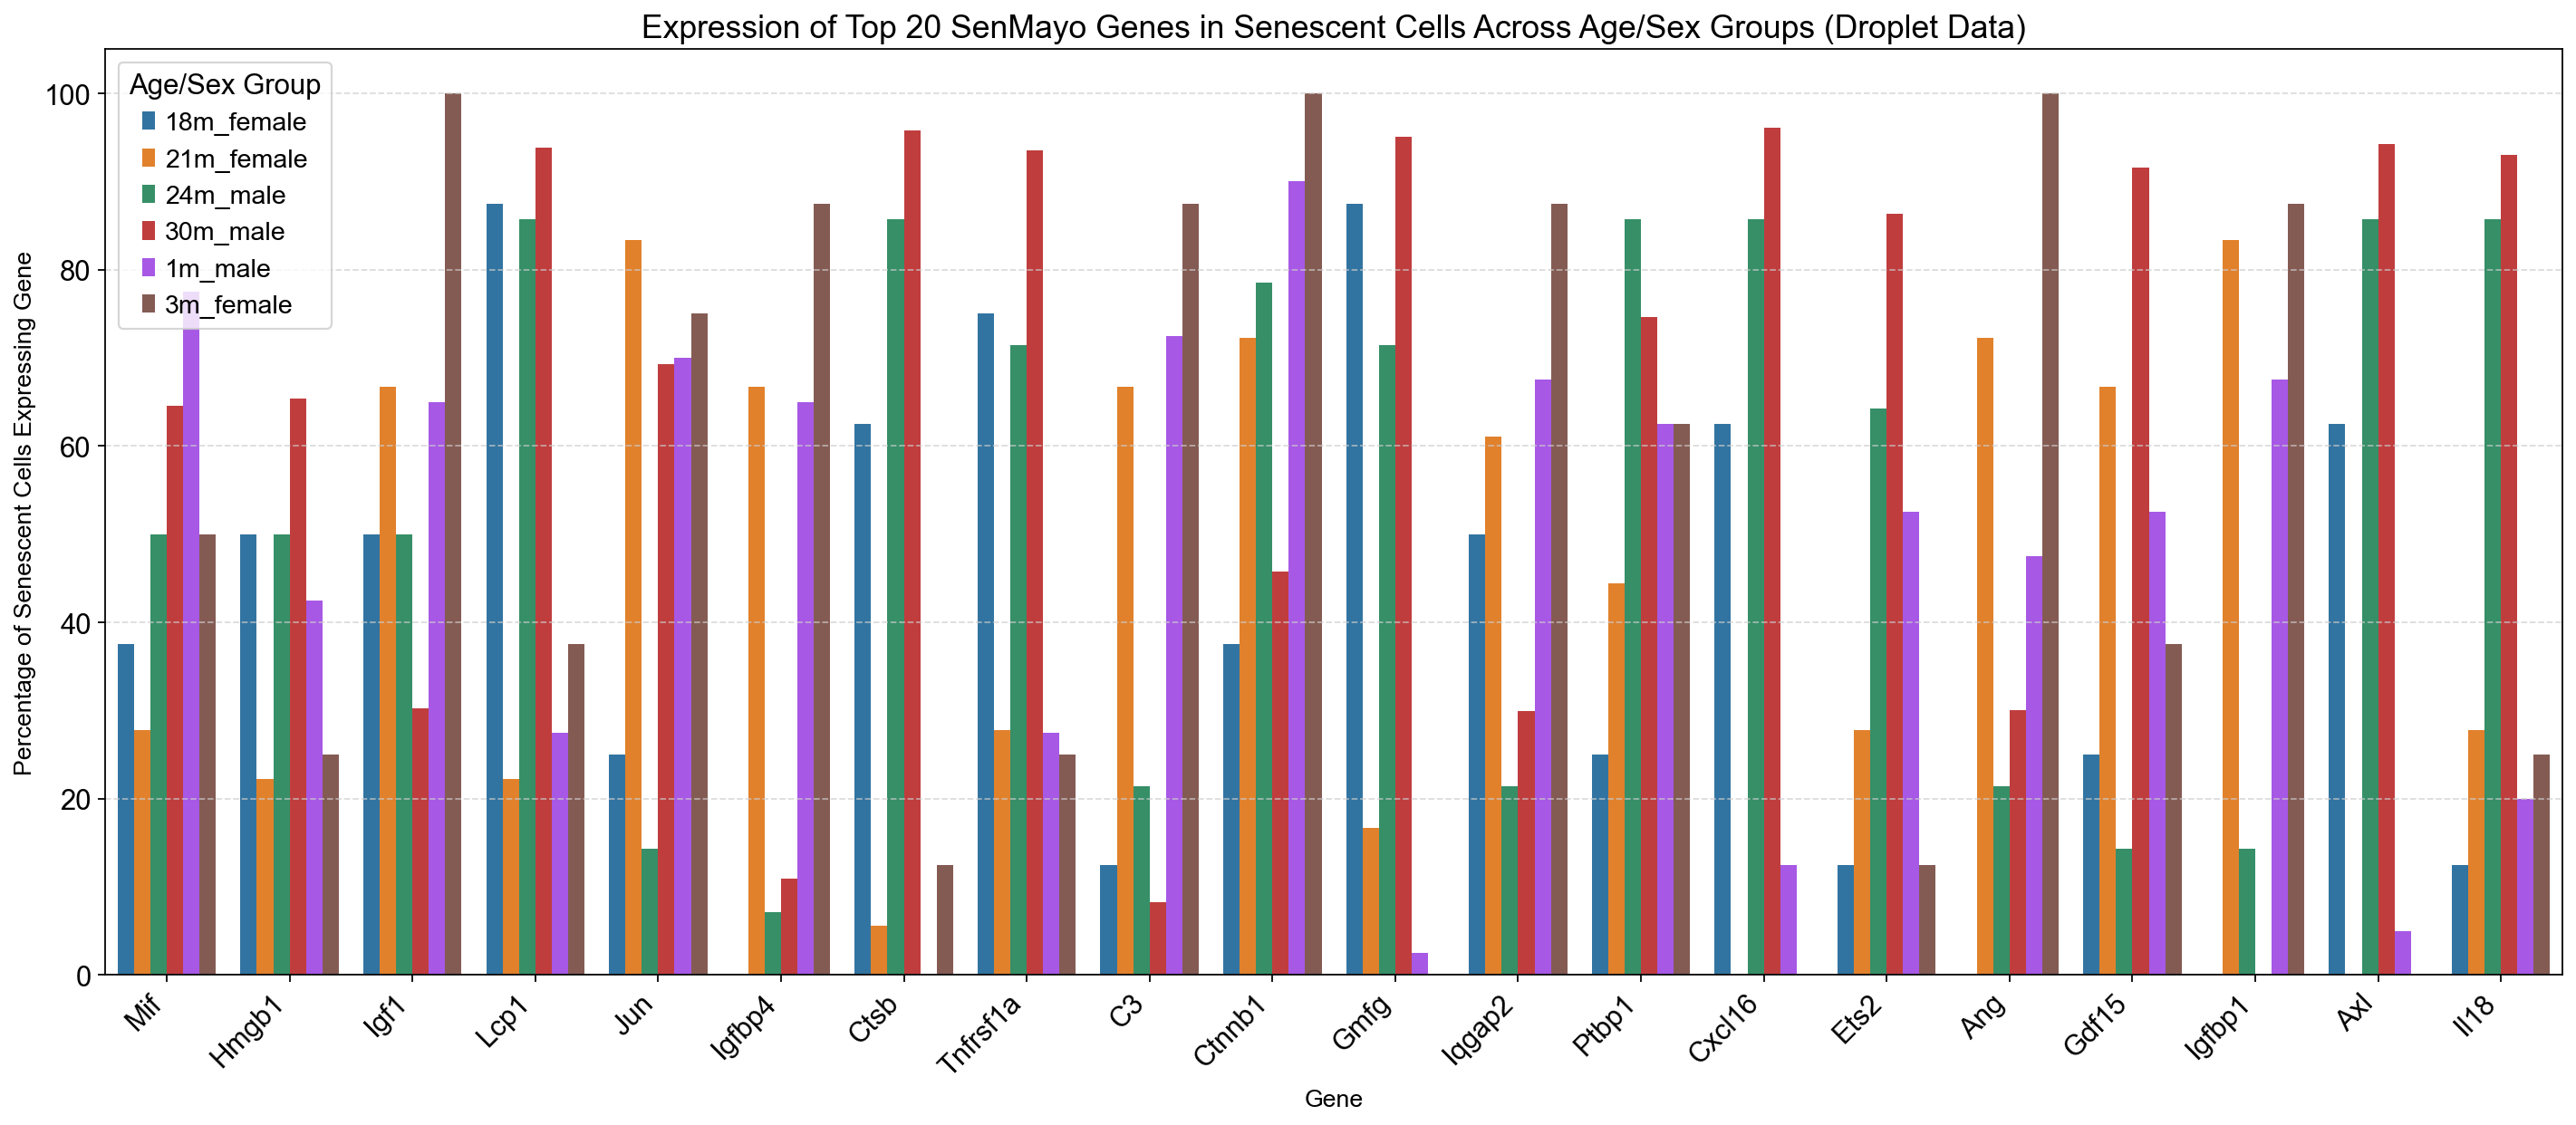

In [25]:
# --- Step 1: Load the data and DEFINE the senescent cell population ---
adata = sc.read_h5ad("Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad")

# --- NEW SETUP BLOCK ---
# Define which cells are "high in SenMayo" using the correct data-driven threshold for DROPLET data.
print("--- Defining senescent population based on data-driven threshold for DROPLET data ---")
# THIS IS THE FIX: Using the correct threshold for the droplet data.
senmayo_threshold = 1.5 
adata.obs['is_high_SenMayo'] = adata.obs['SenMayo_score'] > senmayo_threshold
num_senescent_cells = adata.obs['is_high_SenMayo'].sum()
print(f"Found {num_senescent_cells} cells with SenMayo score > {senmayo_threshold}")
# ---------------------


# --- Step 2: Identify the Top 20 Most Frequently Expressed SenMayo Genes ---
# This part of the logic remains the same: find the most common genes across the whole dataset.
print("\n--- Identifying the top 20 most expressed SenMayo genes ---")
try:
    senmayo_gene_sets = gp.read_gmt(path="SAUL_SEN_MAYO.v2025.1.Mm.gmt")
    senmayo_genes = list(senmayo_gene_sets["SAUL_SEN_MAYO"])
except FileNotFoundError:
    print("Error: SAUL_SEN_MAYO.v2025.1.Mm.gmt not found.")
    senmayo_genes = []

if senmayo_genes:
    senmayo_genes_in_adata = [gene for gene in senmayo_genes if gene in adata.var_names]
    full_expression = adata[:, senmayo_genes_in_adata].X

    if scipy.sparse.issparse(full_expression):
        full_expression_dense = full_expression.toarray()
    else:
        full_expression_dense = full_expression

    percent_expressing_all = (full_expression_dense > 0).mean(axis=0) * 100
    
    percent_expressing_df = pd.DataFrame({
        'gene': senmayo_genes_in_adata,
        'percent_expressing': percent_expressing_all
    }).sort_values(by='percent_expressing', ascending=False)
    
    top_20_senmayo_genes = percent_expressing_df['gene'].head(20).tolist()
    print("Top 20 SenMayo genes identified.")
else:
    top_20_senmayo_genes = []


# --- Step 3: Subset the data to only include the high SenMayo cells ---
if top_20_senmayo_genes and num_senescent_cells > 0:
    # CORRECTED: Dynamically report the number of cells being subsetted.
    print(f"\n--- Subsetting for the {num_senescent_cells} high SenMayo cells ---")
    senmayo_cells_adata = adata[adata.obs['is_high_SenMayo']].copy()

    # --- Step 4: Calculate expression percentage of top 20 genes, grouped by age_sex ---
    print("\n--- Calculating expression percentages within age groups ---")
    age_sex_groups = senmayo_cells_adata.obs['age_sex'].unique()
    results_list = []

    for group in age_sex_groups:
        group_adata = senmayo_cells_adata[senmayo_cells_adata.obs['age_sex'] == group]
        group_expression = group_adata[:, top_20_senmayo_genes].X
        
        if scipy.sparse.issparse(group_expression):
            group_expression_dense = group_expression.toarray()
        else:
            group_expression_dense = group_expression
        
        if group_expression_dense.shape[0] > 0:
            group_percent_expressing = (group_expression_dense > 0).mean(axis=0) * 100
        else:
            group_percent_expressing = [0] * len(top_20_senmayo_genes)

        for i, gene in enumerate(top_20_senmayo_genes):
            results_list.append({
                'gene': gene,
                'age_sex': group,
                'percent_expressing': group_percent_expressing[i]
            })

    results_df = pd.DataFrame(results_list)

    # --- Step 5: Visualize the results ---
    print("\n--- Generating plot ---")
    plt.figure(figsize=(18, 8))
    
    sns.barplot(
        data=results_df,
        x='gene',
        y='percent_expressing',
        hue='age_sex'
    )
    
    # Updated title to specify the dataset
    plt.title('Expression of Top 20 SenMayo Genes in Senescent Cells Across Age/Sex Groups (Droplet Data)', fontsize=16)
    plt.ylabel('Percentage of Senescent Cells Expressing Gene', fontsize=12)
    plt.xlabel('Gene', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Age/Sex Group')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
elif num_senescent_cells == 0:
    print("\nAnalysis stopped because no cells were identified as high in the SenMayo signature with the current threshold.")

Loading droplet data from Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad...

Loading FACS data from Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad...

Calculating average gene expression per cell type...


C:\Users\lukas\AppData\Local\Temp\ipykernel_27200\3253595696.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  facs_avg_exp = facs_df.groupby('cell_type').mean()
C:\Users\lukas\AppData\Local\Temp\ipykernel_27200\3253595696.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  droplet_avg_exp = droplet_df.groupby('cell_type').mean()


Found 20116 common genes between the two datasets.
Computing correlation matrix...
Generating heatmap...


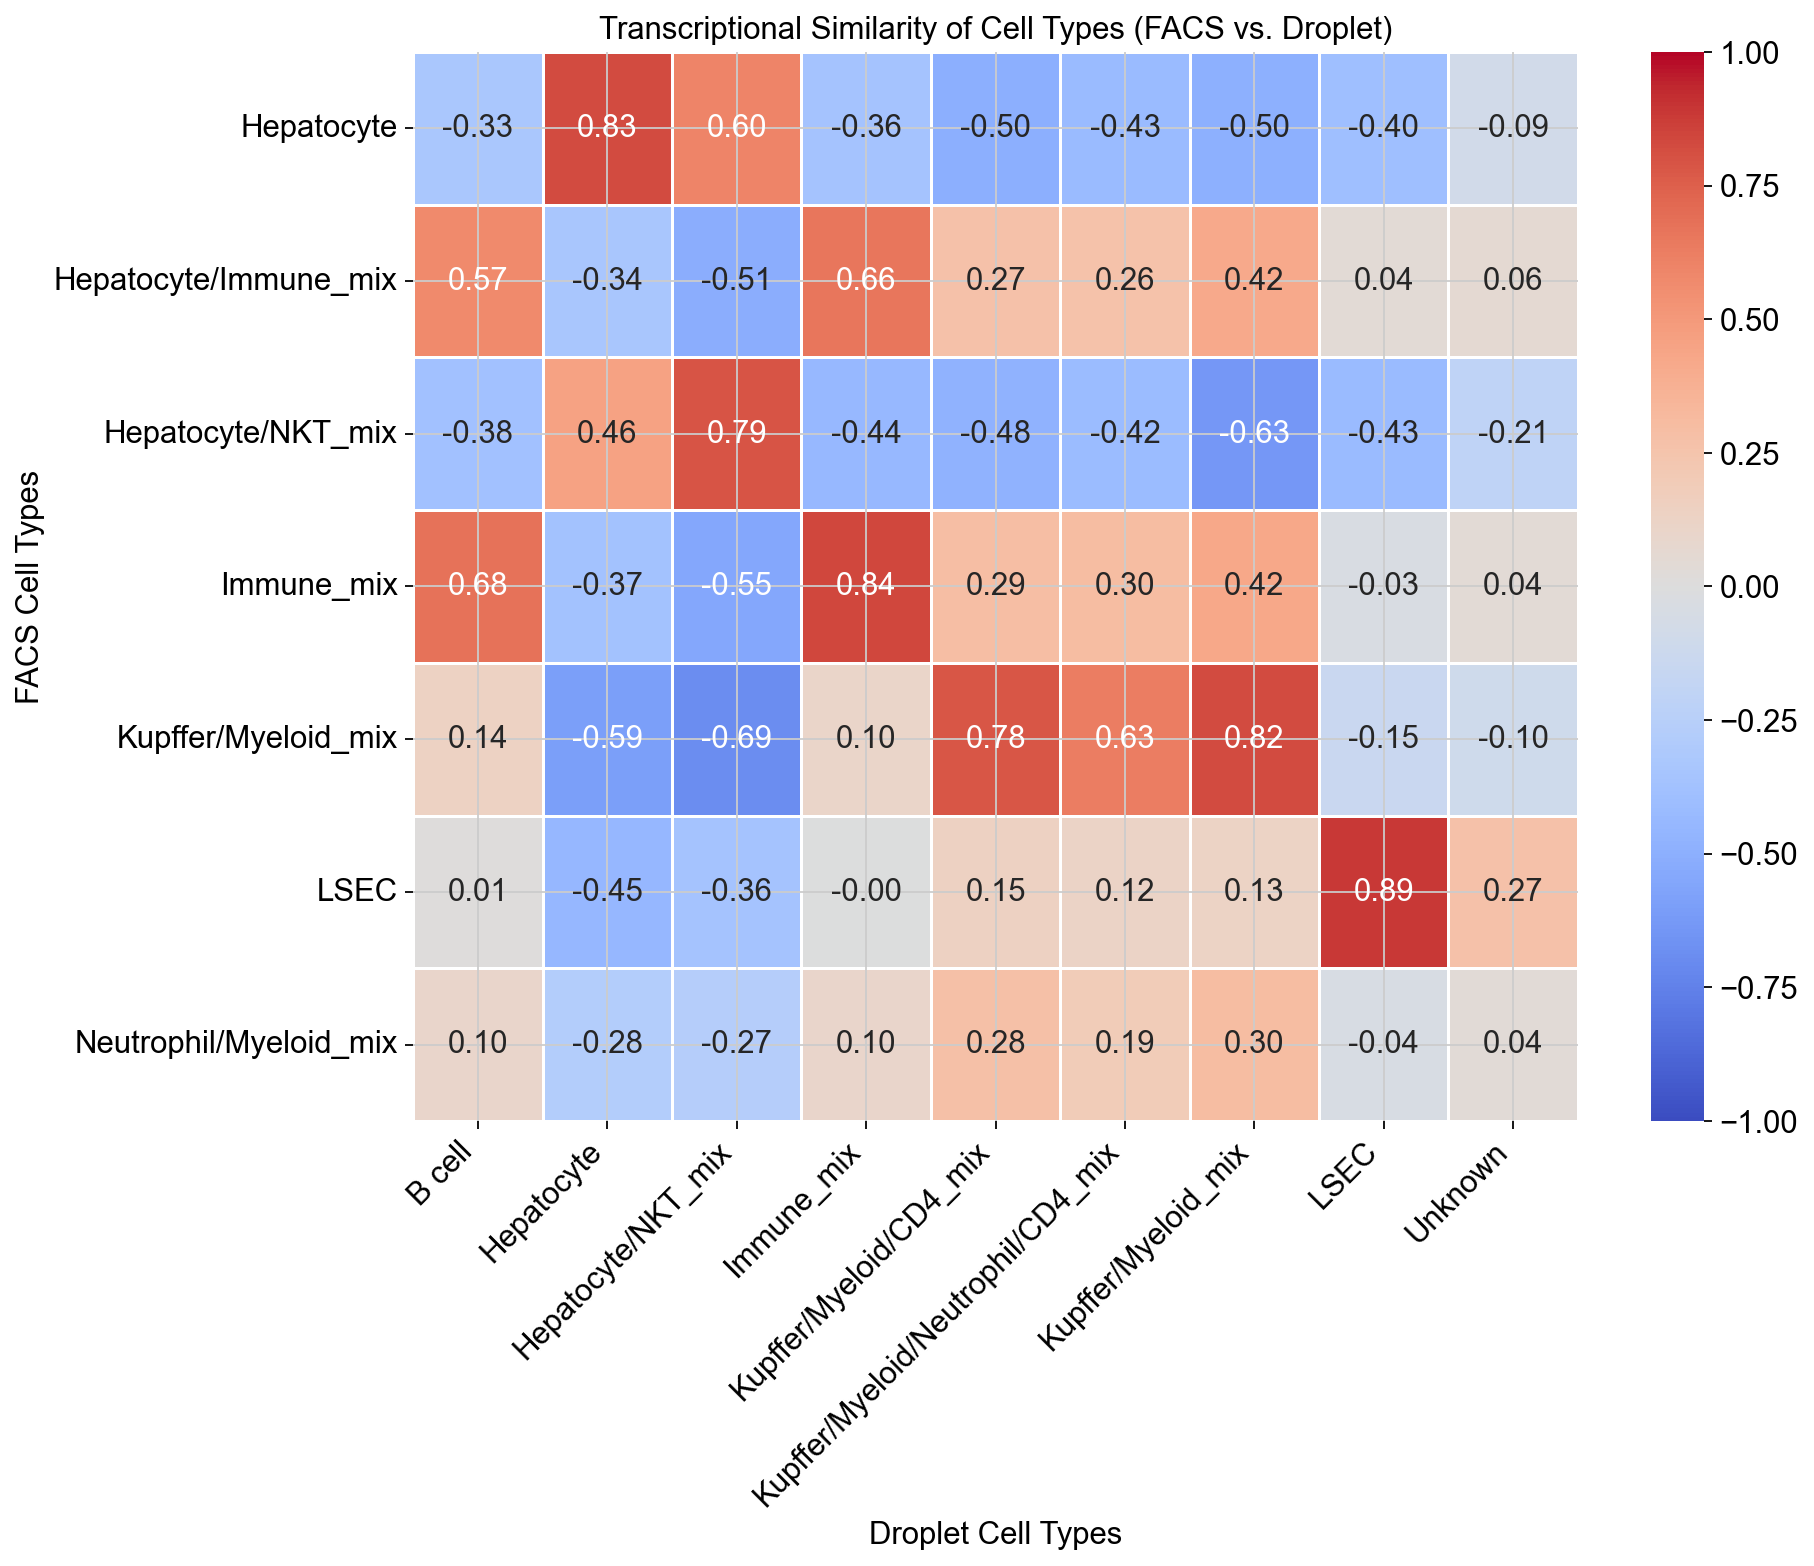

In [27]:

# --- Step 1: Define file paths ---
# IMPORTANT: These files should contain normalized gene expression data,
# not just PCA/UMAP results. They need the full gene matrix.
file_droplet = "Liver_droplet_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"
file_facs = "Liver_facs_normalized_HVG_reduced_clustered_annotated_all_scores.h5ad"

# --- Step 2: Load each dataset ---
print(f"Loading droplet data from {file_droplet}...")
adata_droplet = sc.read_h5ad(file_droplet)

print(f"\nLoading FACS data from {file_facs}...")
adata_facs = sc.read_h5ad(file_facs)

# --- Step 3: Ensure data is in a comparable format (pandas DataFrame) ---
# We use .to_df() to get a (cells x genes) DataFrame
facs_df = adata_facs.to_df()
droplet_df = adata_droplet.to_df()

# Add the cell type annotations to these dataframes
facs_df['cell_type'] = adata_facs.obs['cell_type'].values
droplet_df['cell_type'] = adata_droplet.obs['cell_type'].values

# --- Step 4: Calculate average expression for each cell type ("pseudo-bulk") ---
# We group by cell type and calculate the mean for each gene.
# The result is a DataFrame where rows are cell types and columns are genes.
print("\nCalculating average gene expression per cell type...")
facs_avg_exp = facs_df.groupby('cell_type').mean()
droplet_avg_exp = droplet_df.groupby('cell_type').mean()

# --- Step 5: Find common genes and align the data ---
# The correlation can only be calculated on genes present in both datasets.
common_genes = facs_avg_exp.columns.intersection(droplet_avg_exp.columns)
print(f"Found {len(common_genes)} common genes between the two datasets.")

# Filter both average expression matrices to keep only common genes
# We also transpose (.T) so that genes are rows and cell types are columns, which is standard for correlation.
facs_avg_exp_aligned = facs_avg_exp[common_genes].T
droplet_avg_exp_aligned = droplet_avg_exp[common_genes].T

# --- Step 6: Calculate the Pearson correlation between the two sets of cell types ---
# This computes the correlation between every column in the FACS data
# and every column in the droplet data.
print("Computing correlation matrix...")
correlation_matrix = pd.DataFrame(
    index=facs_avg_exp_aligned.columns, 
    columns=droplet_avg_exp_aligned.columns
)

for facs_type in facs_avg_exp_aligned.columns:
    for droplet_type in droplet_avg_exp_aligned.columns:
        correlation = facs_avg_exp_aligned[facs_type].corr(droplet_avg_exp_aligned[droplet_type])
        correlation_matrix.loc[facs_type, droplet_type] = correlation

# Convert the matrix to numeric type for plotting
correlation_matrix = correlation_matrix.astype(float)

# --- Step 7: Visualize the correlation matrix as a heatmap ---
print("Generating heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values
    fmt=".2f",           # Format to two decimal places
    cmap="coolwarm",     # Use a diverging colormap (high correlation = warm, low = cool)
    linewidths=.5,
    vmin=-1, vmax=1       # Set the color scale from -1 to 1 for correlation
)
plt.title("Transcriptional Similarity of Cell Types (FACS vs. Droplet)")
plt.xlabel("Droplet Cell Types")  # The columns are from the droplet data
plt.ylabel("FACS Cell Types")     # The rows are from the FACS data
plt.xticks(rotation=45, ha='right') # Rotate column labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Overall there is good corroboration between the cell types, even if they are not the same cells or method of sequencing, that gives an indication that the annotations were successful.